#### Last edited by Claire Valva on August 4, 2018

## Mean Z histograms and departure from climatological means

##### to do:

1. figure out why I can't access time as a variable when uploading netcdf file

##### added:
1. Superposed the histograms of total geopotential and those of geoptential using climatological-mean monthly means (no interannual variabilities in the monthly mean) - mean over month and lon, on the same axes with different colors
2. Superpose the histograms of daily geopotential anomalies and those of 4-day average anomalies on the same axes with different colors


#### file details: 
will be using file: 1979-2016-300hPa-40.5N-z.nc which is currently located in ~/uncategorized data

This file contains a single 2D array called “z”, whose dimension is (240, 55520). The first dimension is longitude, 1.5 degree interval from 0 to 358.5 (0 is Greenwich Mean). The second dimension is time, 6 hours apart, from 00 UTC January 1, 1979 to 18 UTC December 31, 2016. The unit is meters^2/sec^2. Divide by g = 9.81 m/s^2 to obtain geopotential height, the altitude at which you find 300 hPa.

In [1]:
#import packages
import numpy as np
from netCDF4 import Dataset, num2date # This is to read .nc files and time array
from scipy.signal import get_window, csd
from scipy.fftpack import fft, ifft, fftshift, fftfreq
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import pandas as pd
import datetime
from math import pi
import csv
from IPython.display import display, Markdown, Latex
import seaborn as sns

In [2]:
#import file
filepath = '/home/clairev/uncategorized-data/1979-2016-300hPa-40.5N-z.nc' # Location of the file
fileobj = Dataset(filepath, mode='r')

# Check what's in there
fileobj

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): longitude(240), time(55520)
    variables(dimensions): float32 z(time,longitude)
    groups: 

In [3]:
#set indicies/number of things
number_entries = int(fileobj.dimensions['time'].size)
number_days = int(number_entries / 4)
number_lon = fileobj.dimensions['longitude'].size
year_number = 2016 - 1979

In [4]:
#load coordinates
#so height[i] is the geopotential height at a given time
height = fileobj.variables['z'][:]
g = 1/9.81
height = height*g

#create time array
time_list = []
for i in range(0,55520):
    time_list.append(i*6)
tunit = "hours since 1979-01-01T00:00:00Z"
tarray = num2date(time_list,units = tunit,calendar = 'gregorian')

#create longitude array
lon_increment = 1.5 # The increment of each longitude grid is 1.5
lon_list = [i * lon_increment for i in range(240)]

# Find mean geopotential heights and differences

##### to do: fix lower cell for efficiency

In [5]:
#first get the average of each individual day
days = []
for i in range(number_entries):
    for k in range(number_lon):
        
        #get the longitdue
        lon = lon_list[k]
        
        #get the geopotential heights for the day
        z_temp = height[i][k]
        
        #group them together 
        toappend = {'datetime' : tarray[i], 'lon': lon,
                    'z' : z_temp}
        
        days.append(toappend)

In [6]:
#make this a dataframe
geopot_df = pd.DataFrame(days)

In [7]:
#get day/month/year separately for groupby
geopot_df['month'] = geopot_df['datetime'].apply(lambda x: x.month)
geopot_df['day'] = geopot_df['datetime'].apply(lambda x: x.day)
geopot_df['year'] = geopot_df['datetime'].apply(lambda x: x.year)

In [8]:
#append season to each row
def season_sort(x):
    if x < 3:
        return("winter")
    elif x >= 12:
        return("winter")
    elif x >= 3 and x < 6:
        return("spring")
    elif x >= 6 and x < 9:
        return("summer")
    elif x >= 9 and x < 12:
        return("fall")
    else:
        return("error?")
    
geopot_df["season"] = geopot_df["month"].apply(lambda x: season_sort(x))

In [9]:
#find mean over several vars
geopot_df["dayavg"] = geopot_df.groupby(by=['month', 'year','lon', 'day'])['z'].transform('mean')
geopot_df["monthmean"] = geopot_df.groupby(by=['month', 'year','lon'])['z'].transform('mean')
geopot_df["clim_monthmean"] = geopot_df.groupby(by=['month','lon'])['z'].transform('mean')
geopot_df["seasonmean"] = geopot_df.groupby(by=['year','lon','season'])['z'].transform('mean')

In [10]:
#find the difference between monthmeans and climmonth means
geopot_df["difference_month"] = geopot_df['z'] - geopot_df["monthmean"]
geopot_df["difference_climmonth"] = geopot_df['z'] - geopot_df["clim_monthmean"]

In [29]:
geopot_df["geofrom_climmonth"] = geopot_df["clim_monthmean"] + geopot_df["difference_month"]

In [36]:
#to compare - get the average of four day sections
avg4_df = geopot_df.drop_duplicates(subset=['dayavg'], keep='first', inplace=False)
avg4_df = avg4_df.sort_values(by = ['lon','datetime'])
avg4_df = avg4_df.groupby(np.arange(len(avg4_df))//4).mean()
avg4_df["season"] = avg4_df["month"].apply(lambda x: season_sort(x))

#### set parameters / lon sections for plotting

#set lists of seasons
winter_str = 'month < 3 | month == 12'
spring_str = 'month >= 3 & month <= 5'
summer_str = 'month >= 6 & month <= 8'
fall_str = 'month >= 9 & month <= 11'

season_list = [winter_str, spring_str, summer_str, fall_str]

In [12]:
#set lists of longitude sections
lon_1 = 'lon >= 50 & lon <= 140'
lon_2 = 'lon <= 50 | lon >= 320'
lon_3 = 'lon >= 230 & lon <= 320'
lon_4 = 'lon >= 140 & lon <= 230'

lon_sections = [lon_1, lon_2, lon_3, lon_4]

season_label = ["winter","spring","summer","fall"]

## comparison of total geopotential and geopotential from climatological-mean monthly means

total geopotential = geopotential on a given day
geopotential from climatological-mean monthly means = difference of total geopotential and monthly mean added to climatological-mean monthly means


## season: winter

<Figure size 432x288 with 0 Axes>

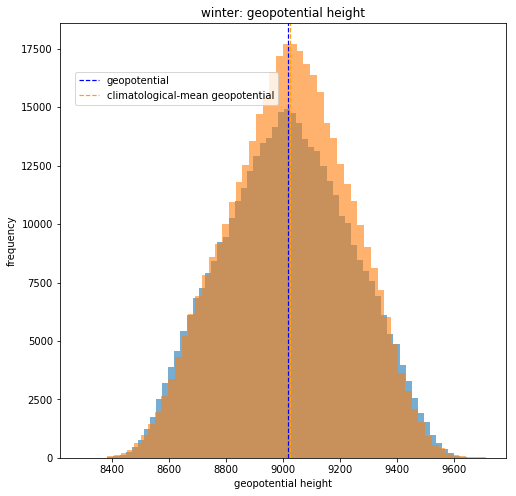

<Figure size 432x288 with 0 Axes>

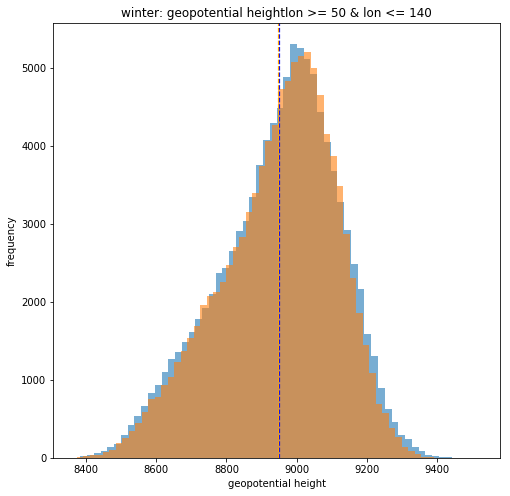

<Figure size 432x288 with 0 Axes>

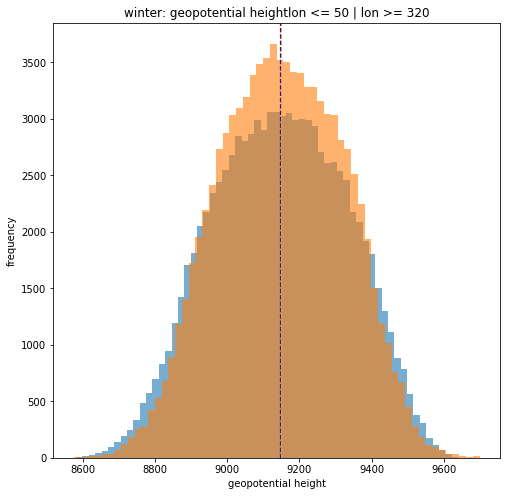

<Figure size 432x288 with 0 Axes>

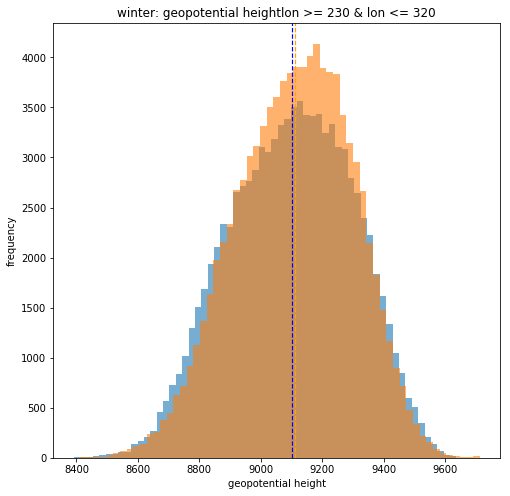

<Figure size 432x288 with 0 Axes>

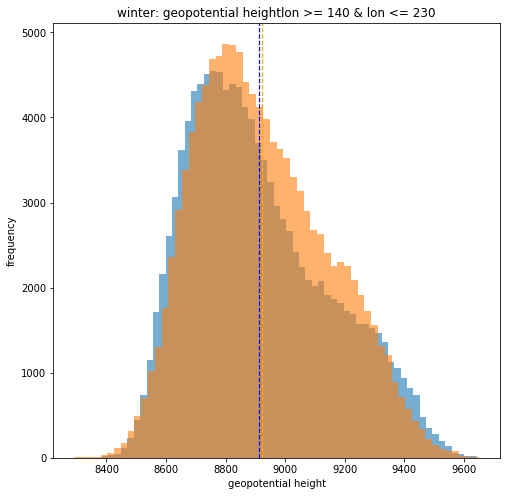

## season: spring

<Figure size 432x288 with 0 Axes>

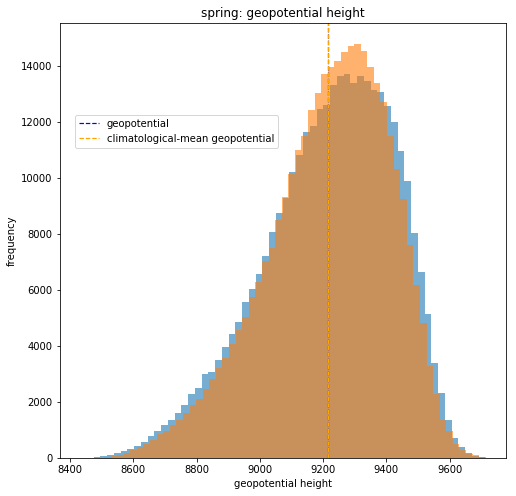

<Figure size 432x288 with 0 Axes>

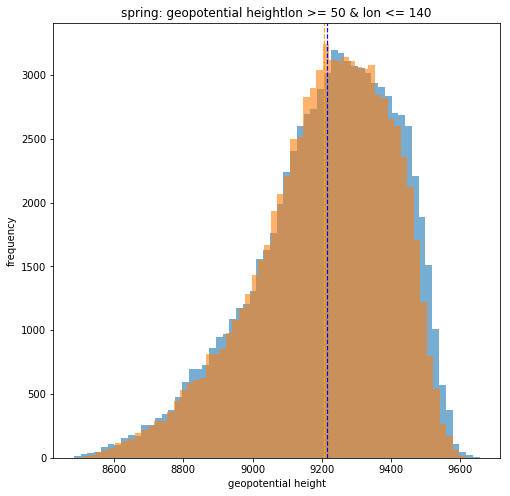

<Figure size 432x288 with 0 Axes>

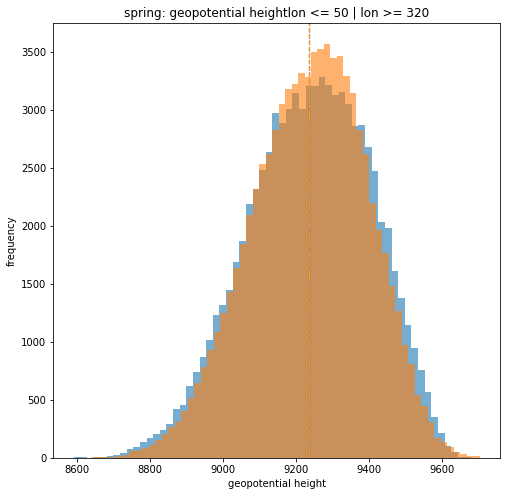

<Figure size 432x288 with 0 Axes>

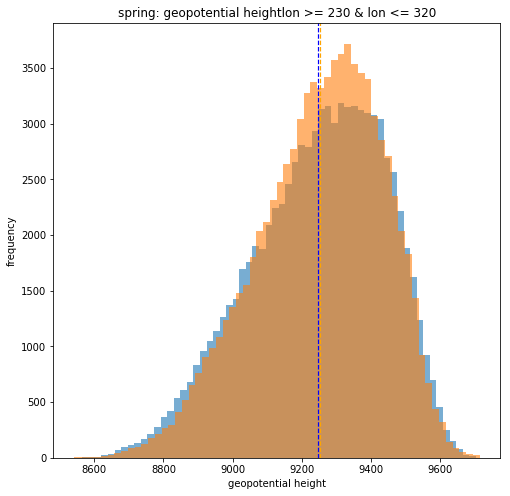

<Figure size 432x288 with 0 Axes>

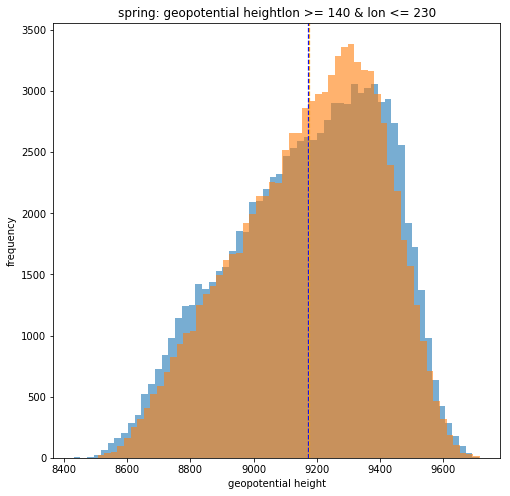

## season: summer

<Figure size 432x288 with 0 Axes>

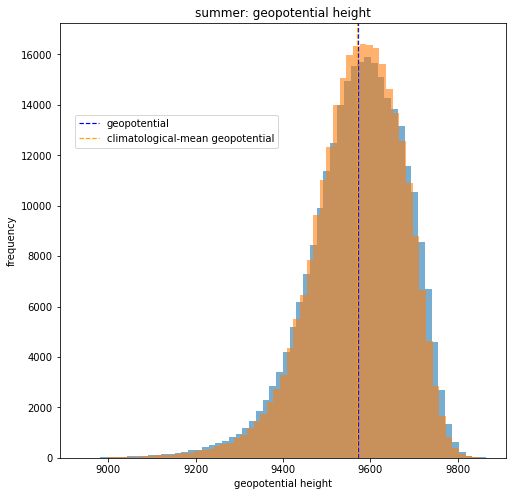

<Figure size 432x288 with 0 Axes>

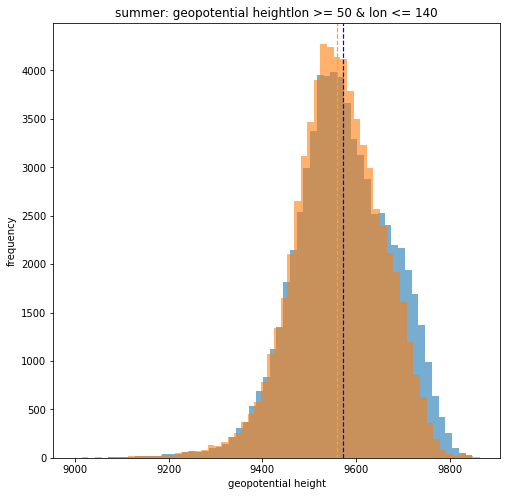

<Figure size 432x288 with 0 Axes>

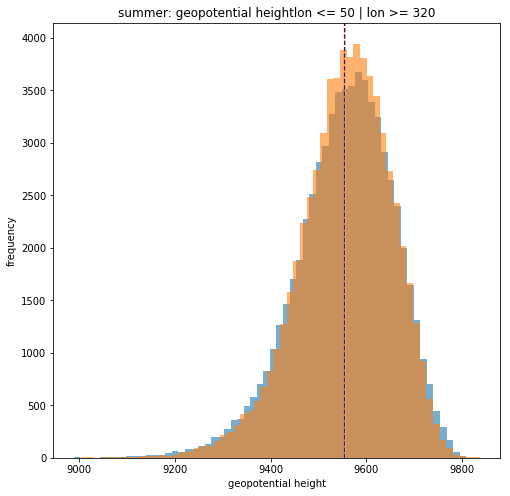

<Figure size 432x288 with 0 Axes>

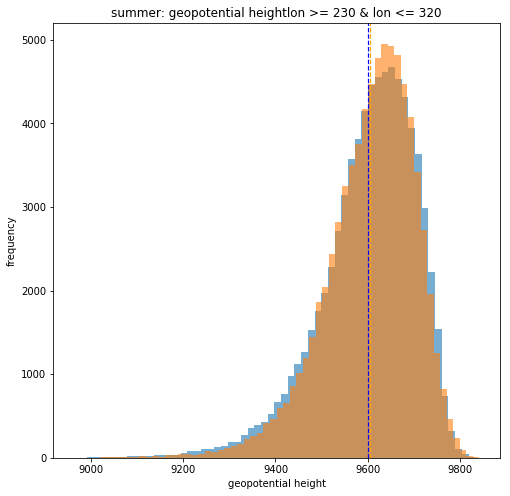

<Figure size 432x288 with 0 Axes>

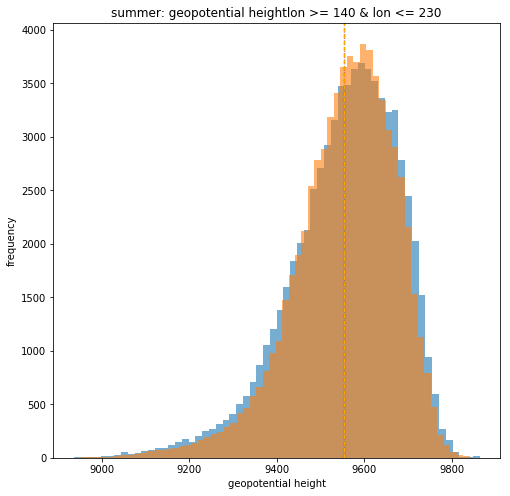

## season: fall

<Figure size 432x288 with 0 Axes>

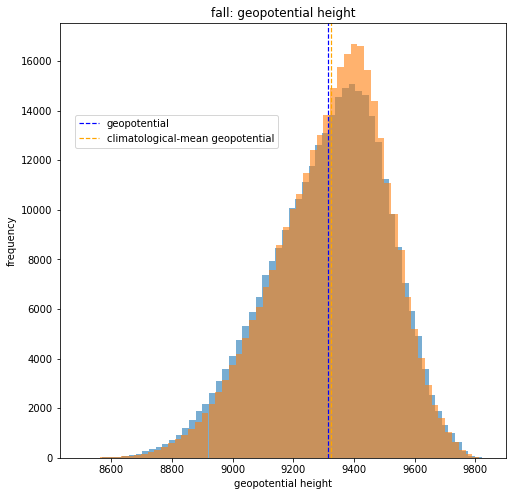

<Figure size 432x288 with 0 Axes>

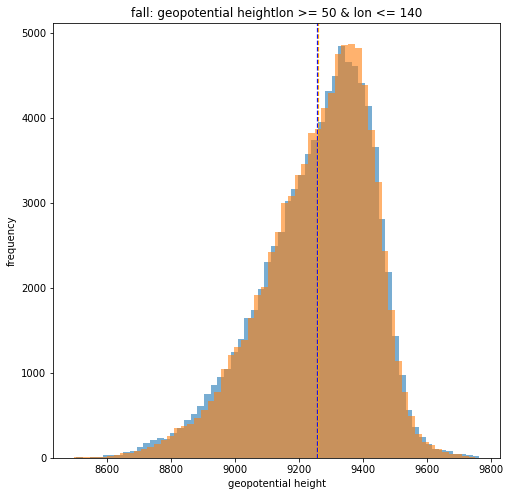

<Figure size 432x288 with 0 Axes>

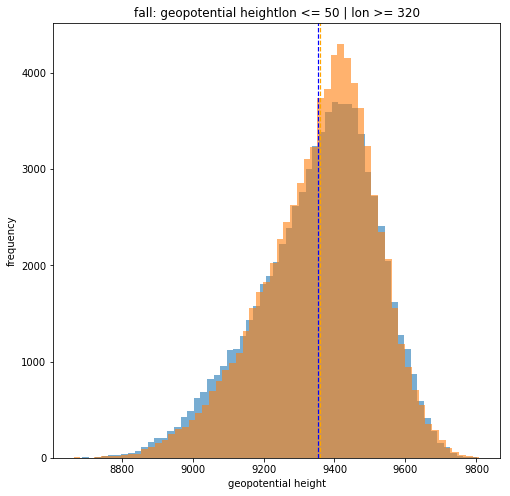

<Figure size 432x288 with 0 Axes>

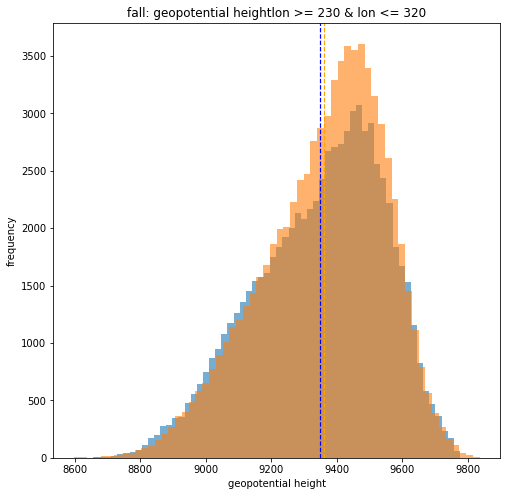

<Figure size 432x288 with 0 Axes>

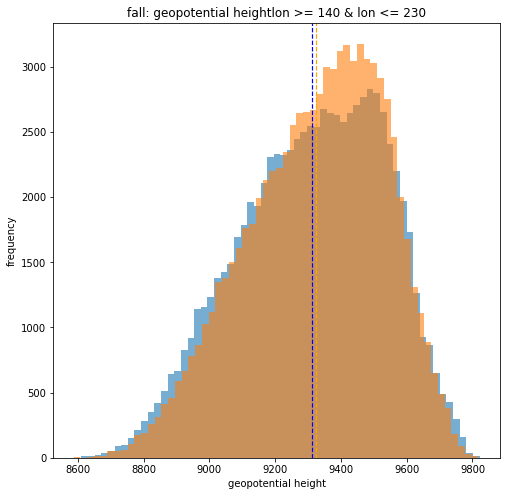

In [60]:
#drop the duplicates so am only pltting one point in each place
day_df = geopot_df.drop_duplicates(subset=['dayavg'], keep='first', inplace=False)
label_list = ["geopotential", "climatological-mean geopotential"]

for season in season_list:
    
    #display season
    display(Markdown('## season: ' + season))
    
    #get the correct dataframe
    plot_df = day_df[day_df["season"] == season]
    
    #plot the histogram for the entire season
    plt.clf();
    plt.figure(figsize=(8,8))
    plt.hist(plot_df['dayavg'], bins = 60, alpha = .6)
    plt.hist(plot_df['geofrom_climmonth'], bins = 60, alpha = .6)
    plt.axvline(plot_df['dayavg'].mean(), color='blue', linestyle='dashed', linewidth=1.2)
    plt.axvline(plot_df['geofrom_climmonth'].mean(), color='orange', linestyle='dashed', linewidth=1.2)
    plt.legend(label_list, bbox_to_anchor=[0.5, 0.8],ncol=1)
    plt.ylabel('frequency')
    plt.xlabel('geopotential height')
    plt.title(season + ': geopotential height');
    plt.show()
    
    
    
    for section in lon_sections:
        
        #get the correct dataframe
        section_df = plot_df.query(section)
        
        #plot the figure
        plt.clf();
        plt.figure(figsize=(8,8))
        plt.hist(section_df['dayavg'], bins = 60, alpha = .6)
        plt.hist(section_df['geofrom_climmonth'], bins = 60, alpha = .6)
        plt.axvline(section_df['dayavg'].mean(), color='blue', linestyle='dashed', linewidth=1.2)
        plt.axvline(section_df['geofrom_climmonth'].mean(), color='orange', linestyle='dashed', linewidth=1.2)
        plt.ylabel('frequency')
        plt.xlabel('geopotential height')
        plt.title(season + ': geopotential height' + section);
        plt.show()
        
    i = i + 1

### repeat plots but with axis as log10 for better look at tails

## season: winter

<Figure size 432x288 with 0 Axes>

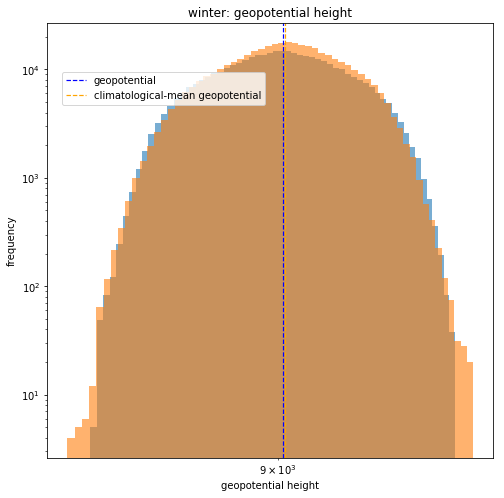

<Figure size 432x288 with 0 Axes>

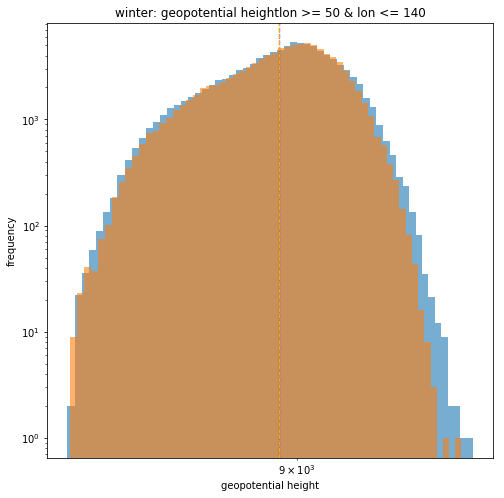

<Figure size 432x288 with 0 Axes>

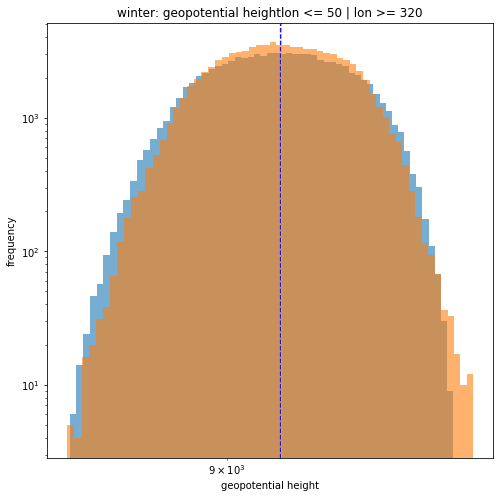

<Figure size 432x288 with 0 Axes>

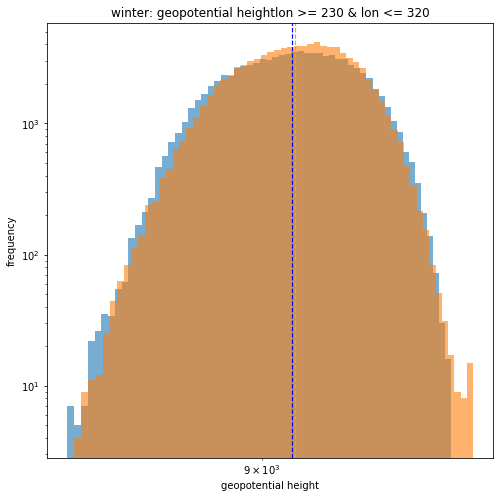

<Figure size 432x288 with 0 Axes>

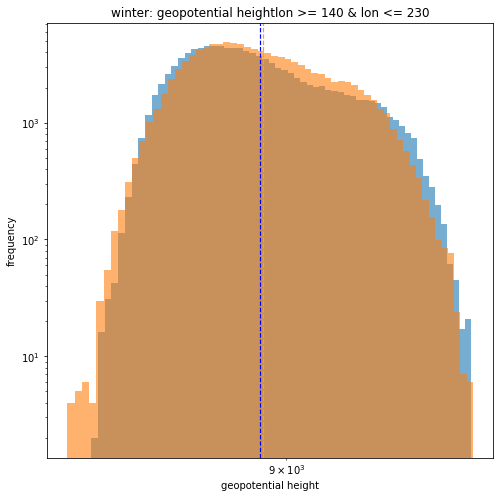

## season: spring

<Figure size 432x288 with 0 Axes>

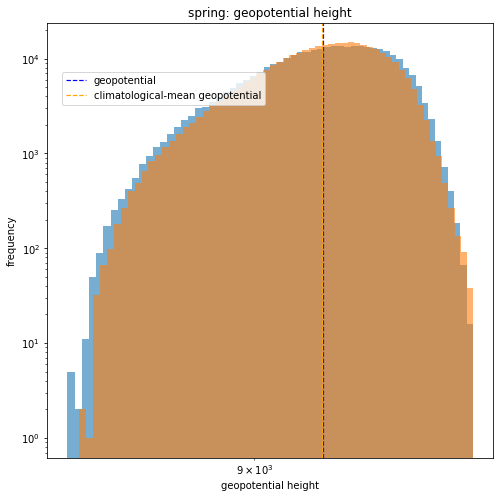

<Figure size 432x288 with 0 Axes>

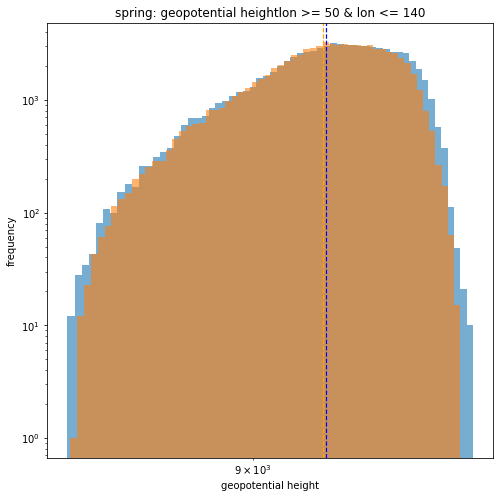

<Figure size 432x288 with 0 Axes>

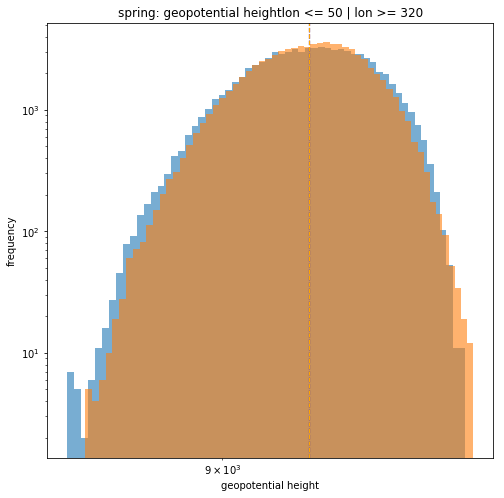

<Figure size 432x288 with 0 Axes>

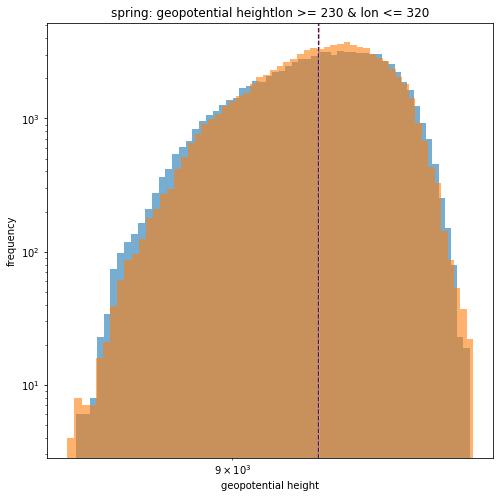

<Figure size 432x288 with 0 Axes>

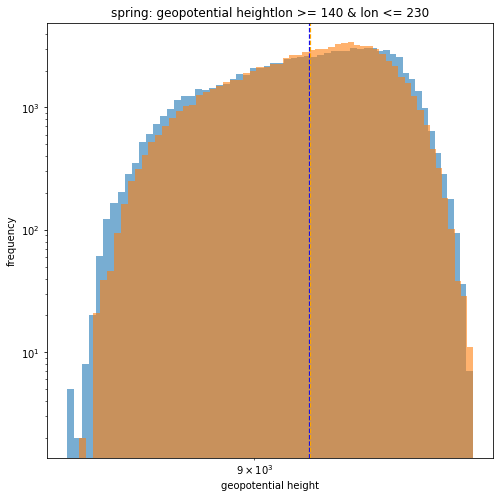

## season: summer

<Figure size 432x288 with 0 Axes>

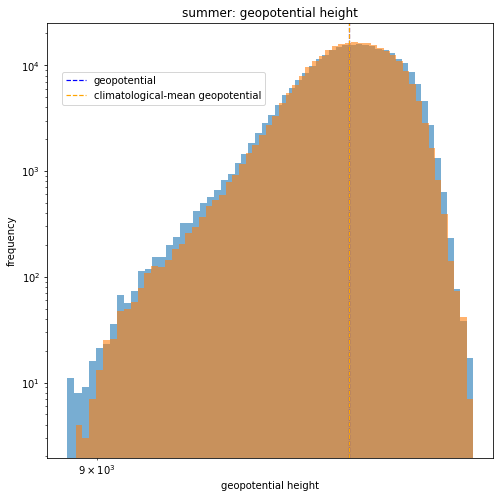

<Figure size 432x288 with 0 Axes>

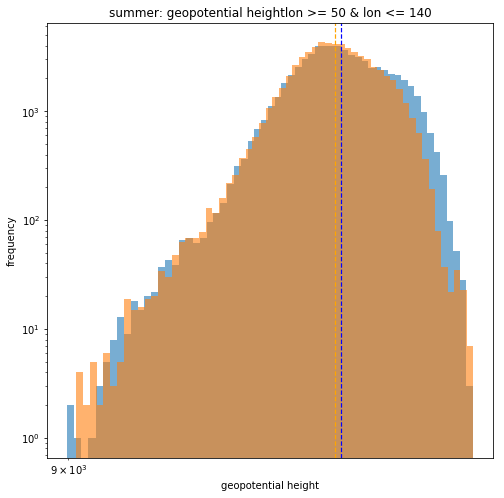

<Figure size 432x288 with 0 Axes>

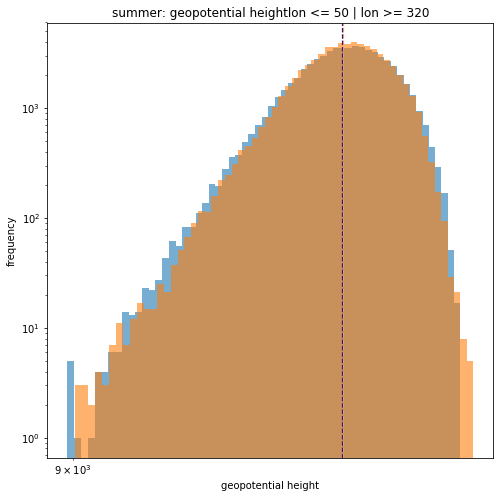

<Figure size 432x288 with 0 Axes>

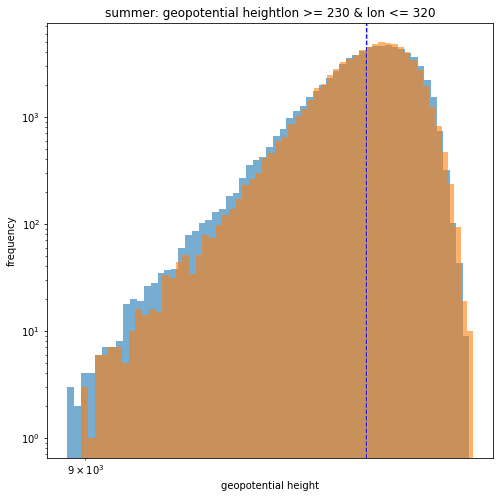

<Figure size 432x288 with 0 Axes>

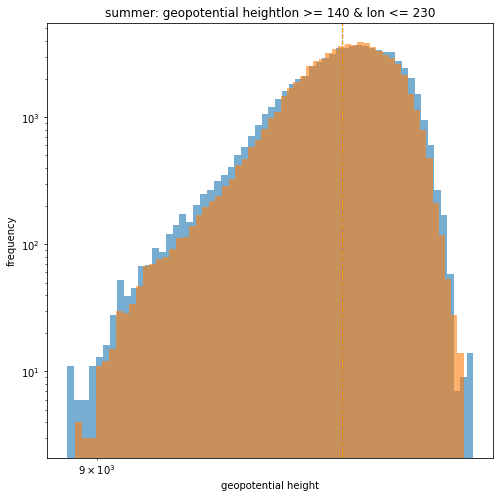

## season: fall

<Figure size 432x288 with 0 Axes>

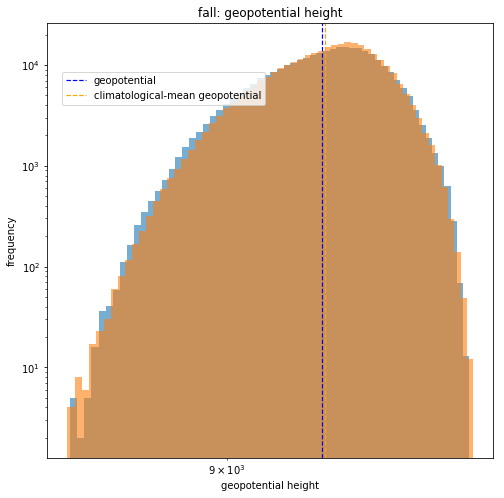

<Figure size 432x288 with 0 Axes>

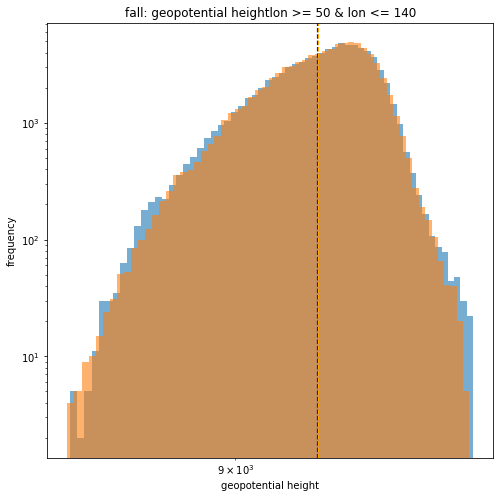

<Figure size 432x288 with 0 Axes>

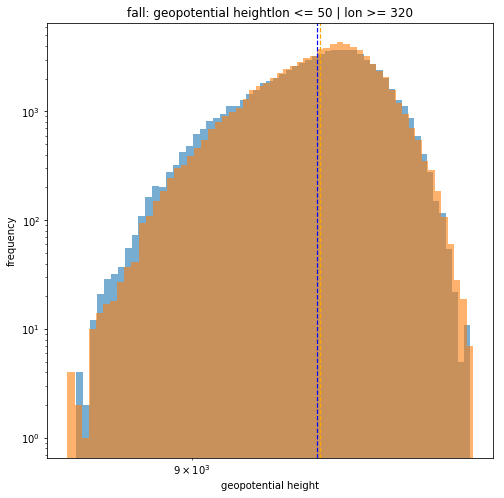

<Figure size 432x288 with 0 Axes>

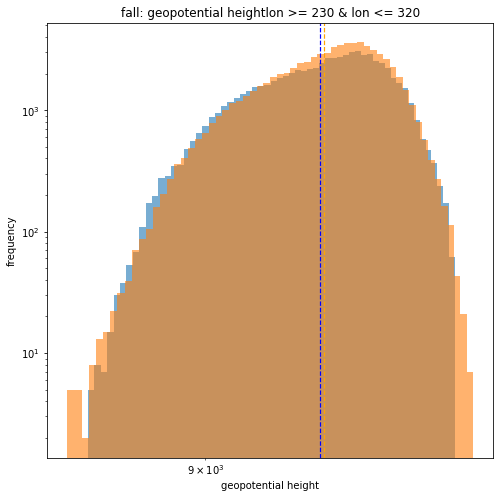

<Figure size 432x288 with 0 Axes>

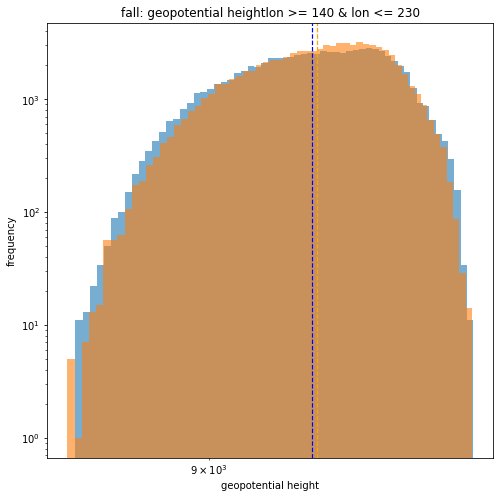

In [61]:
#drop the duplicates so am only pltting one point in each place
day_df = geopot_df.drop_duplicates(subset=['dayavg'], keep='first', inplace=False)
label_list = ["geopotential", "climatological-mean geopotential"]

for season in season_list:
    
    #display season
    display(Markdown('## season: ' + season))
    
    #get the correct dataframe
    plot_df = day_df[day_df["season"] == season]
    
    #plot the histogram for the entire season
    plt.clf();
    plt.figure(figsize=(8,8))
    plt.hist(plot_df['dayavg'], bins = 60, alpha = .6)
    plt.hist(plot_df['geofrom_climmonth'], bins = 60, alpha = .6)
    plt.axvline(plot_df['dayavg'].mean(), color='blue', linestyle='dashed', linewidth=1.2)
    plt.axvline(plot_df['geofrom_climmonth'].mean(), color='orange', linestyle='dashed', linewidth=1.2)
    #plt.xlim(xmin,xmax)
    plt.legend(label_list, bbox_to_anchor=[0.5, 0.8],ncol=1)
    plt.ylabel('frequency')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('geopotential height')
    plt.title(season + ': geopotential height');
    plt.show()
    
    
    
    for section in lon_sections:
        
        #get the correct dataframe
        section_df = plot_df.query(section)
        
        #plot the figure
        plt.clf();
        plt.figure(figsize=(8,8))
        plt.hist(section_df['dayavg'], bins = 60, alpha = .6)
        plt.hist(section_df['geofrom_climmonth'], bins = 60, alpha = .6)
        plt.axvline(section_df['dayavg'].mean(), color='blue', linestyle='dashed', linewidth=1.2)
        plt.axvline(section_df['geofrom_climmonth'].mean(), color='orange', linestyle='dashed', linewidth=1.2)
        plt.xscale('log')
        plt.yscale('log')
        plt.ylabel('frequency')
        plt.xlabel('geopotential height')
        plt.title(season + ': geopotential height' + section);
        plt.show()
        
    i = i + 1

## Comparison of daily anomalies vs. 4day average anomalies

Superposed histograms of daily geopotential anomalies and 4-day average anomalies

(Note that the y-axis is relative percentage given that a 4 day average will have 25% of datapoints as the daily differences.)


In [ ]:
#drop the duplicates so am only pltting one point in each place
day_df = geopot_df.drop_duplicates(subset=['dayavg'], keep='first', inplace=False)
label_list = ["daily geopotential anomaly", "4 day average geopotential anomaly"]

for season in season_list:
    
    #display season
    display(Markdown('## season: ' + season))
    
    #get the correct dataframe
    plot_df = day_df[day_df["season"] == season]
    plot4_df = avg4_df[avg4_df["season"] == season]
    
    #plot the histogram for the entire season
    plt.clf();
    plt.figure(figsize=(8,8))
    plt.hist(plot_df['difference_month'], bins = 60, alpha = .6,
             weights = np.ones_like(plot_df.index) / len(plot_df.index))
    plt.hist(plot4_df['difference_month'], bins = 60, alpha = .6,
             weights = np.ones_like(plot4_df.index) / len(plot4_df.index))
    plt.axvline(plot_df['difference_month'].mean(), color='blue', linestyle='dashed', linewidth=1.2)
    plt.axvline(plot4_df['difference_month'].mean(), color='orange', linestyle='dashed', linewidth=1.2)
    plt.legend(label_list, bbox_to_anchor=[0.5, 0.8],ncol=1)
    plt.ylabel('frequency')
    plt.xlabel('difference from mean geopotential height')
    plt.title(season + ': geopotential height');
    plt.show()
    
    
    
    for section in lon_sections:
        
        #get the correct dataframe
        section_df = plot_df.query(section)
        section4_df = avg4_df.query(section)
        
        #plot the figure
        plt.clf();
        plt.figure(figsize=(8,8))
        plt.hist(section_df['difference_month'], bins = 60, alpha = .6,
                weights = np.ones_like(section_df.index) / len(section_df.index))
        plt.hist(section4_df['difference_month'], bins = 60, alpha = .6,
                weights = np.ones_like(section4_df.index) / len(section4_df.index))
        plt.axvline(section_df['difference_month'].mean(), color='blue', linestyle='dashed', linewidth=1.2)
        plt.axvline(section4_df['difference_month'].mean(), color='orange', linestyle='dashed', linewidth=1.2)
        plt.axvline(section_df['difference_month'].mean(), color='blue', linestyle='dashed', linewidth=1.2)
        plt.axvline(section4_df['difference_month'].mean(), color='orange', linestyle='dashed', linewidth=1.2)
        plt.ylabel('frequency')
        plt.xlabel('difference from mean geopotential height')
        plt.title(season + ': geopotential height' + section);
        plt.show()
        
    i = i + 1

### show with axis log 10 so have a better look at the scales (positive side)

## season: winter

<Figure size 432x288 with 0 Axes>

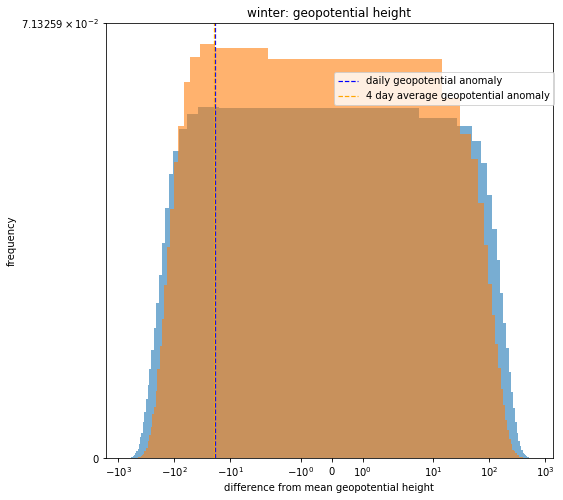

<Figure size 432x288 with 0 Axes>

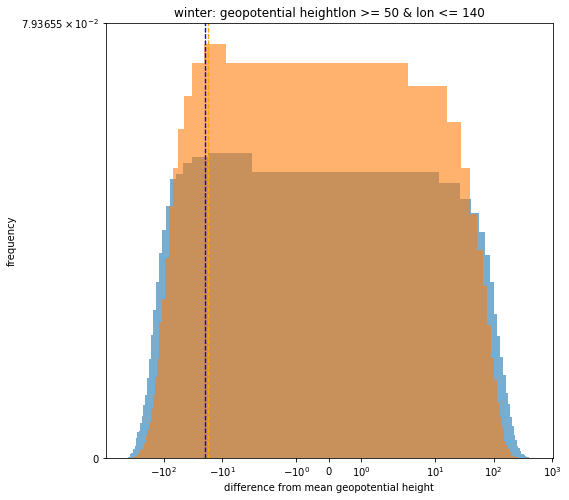

<Figure size 432x288 with 0 Axes>

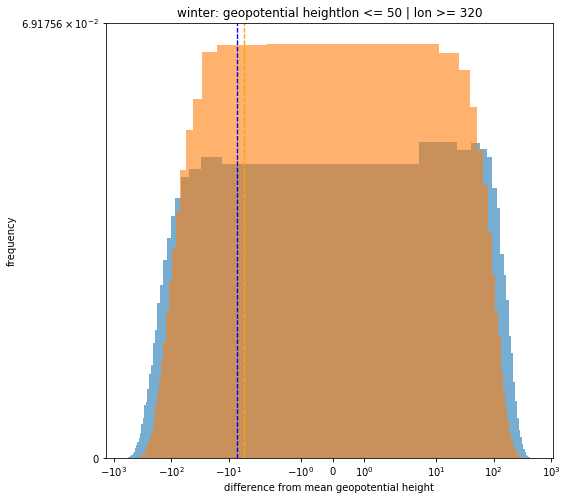

<Figure size 432x288 with 0 Axes>

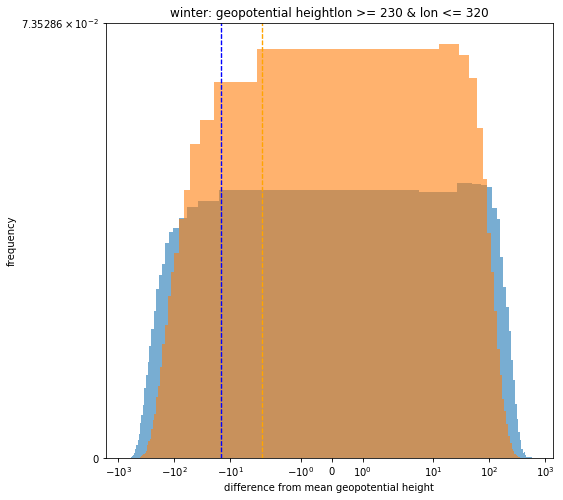

<Figure size 432x288 with 0 Axes>

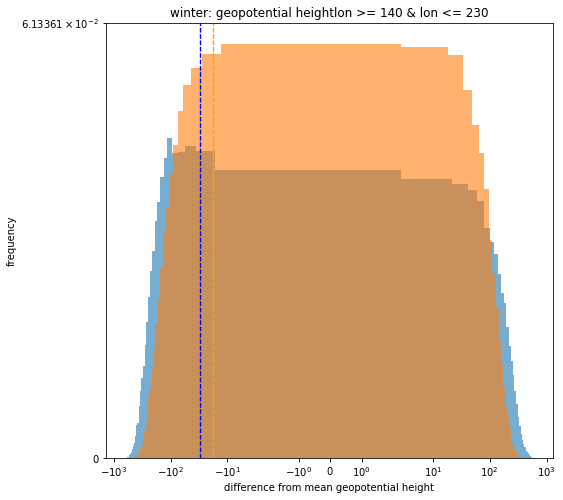

## season: spring

<Figure size 432x288 with 0 Axes>

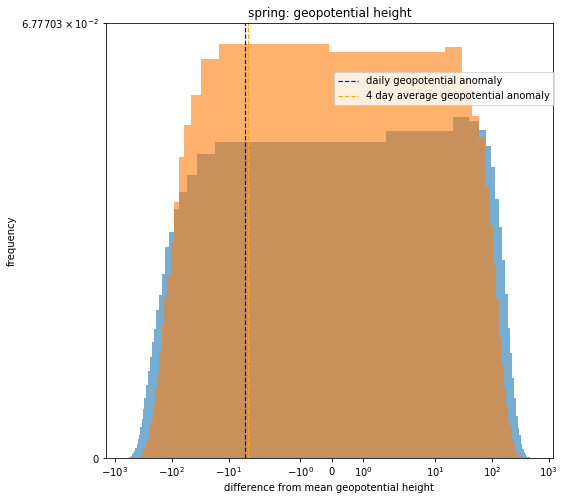

<Figure size 432x288 with 0 Axes>

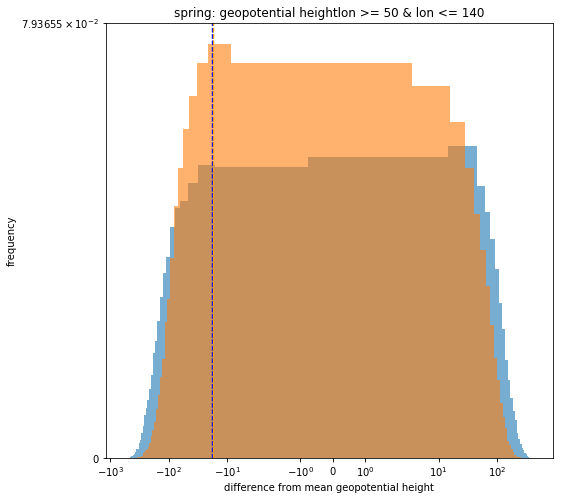

<Figure size 432x288 with 0 Axes>

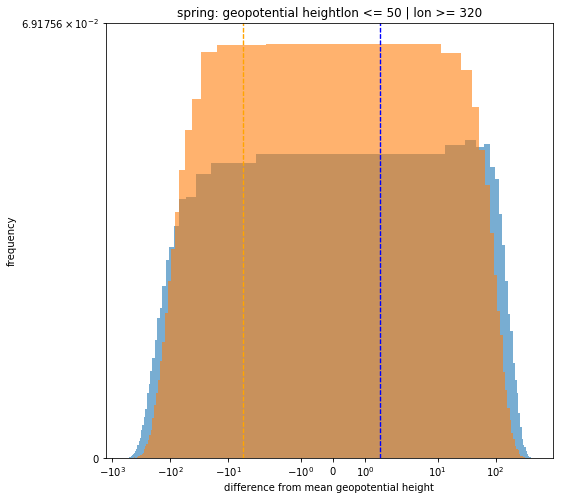

<Figure size 432x288 with 0 Axes>

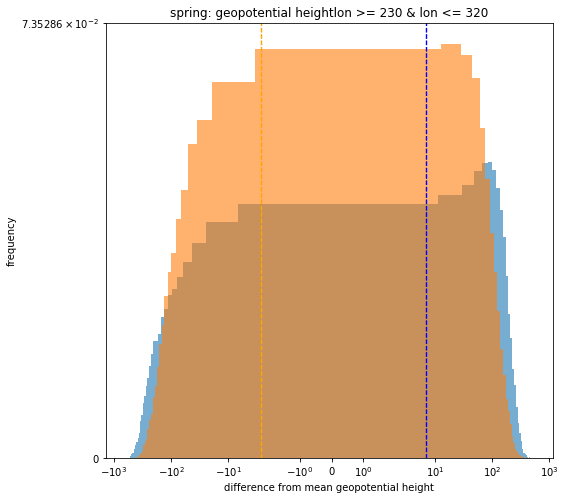

<Figure size 432x288 with 0 Axes>

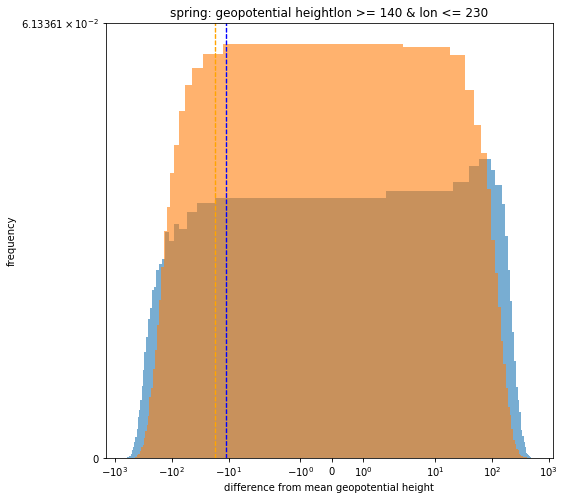

## season: summer

<Figure size 432x288 with 0 Axes>

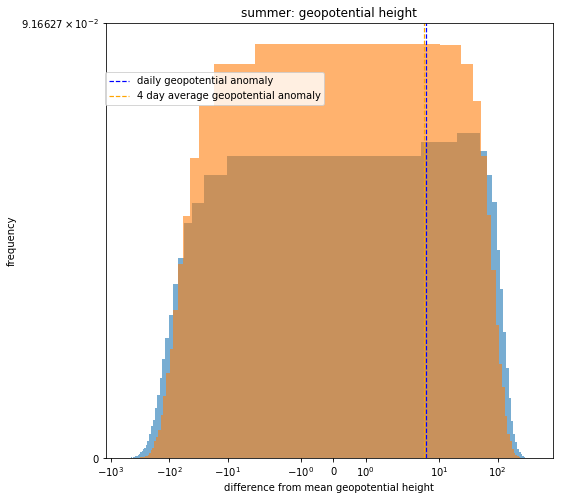

<Figure size 432x288 with 0 Axes>

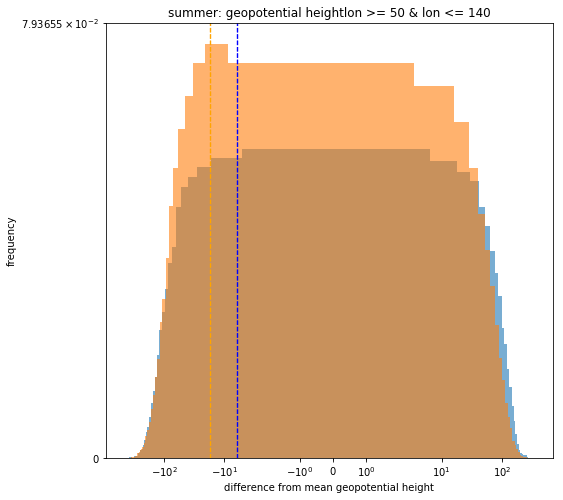

<Figure size 432x288 with 0 Axes>

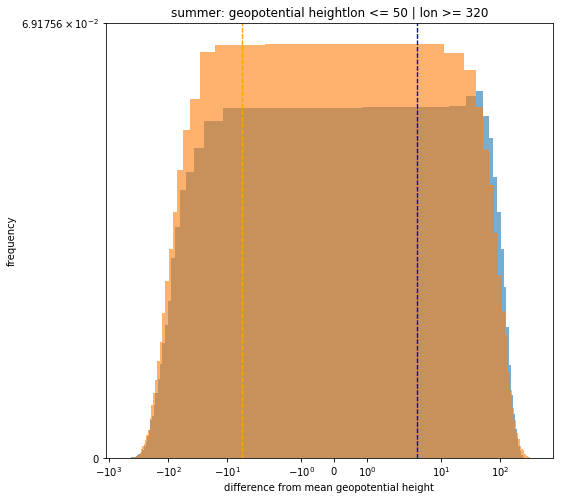

<Figure size 432x288 with 0 Axes>

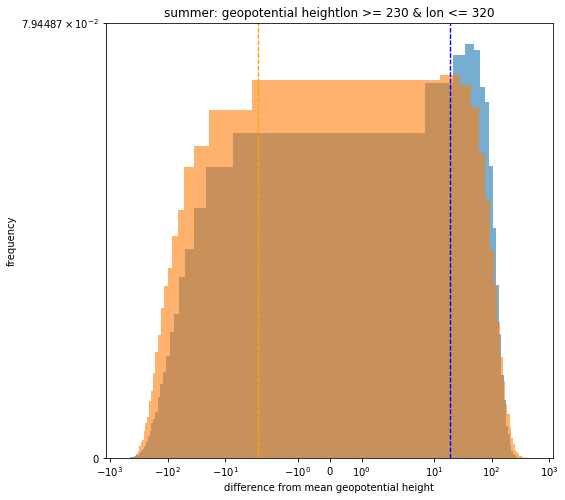

<Figure size 432x288 with 0 Axes>

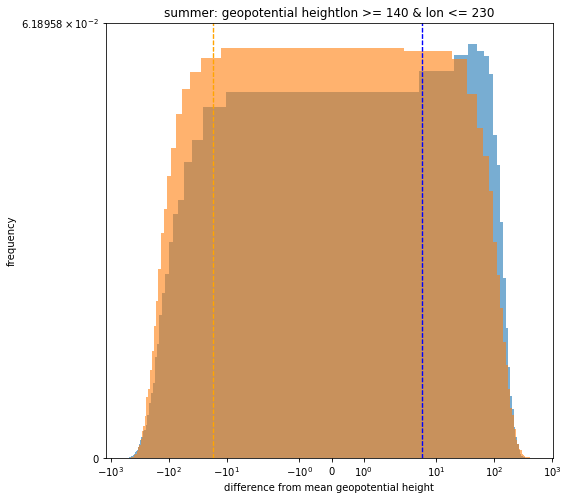

## season: fall

<Figure size 432x288 with 0 Axes>

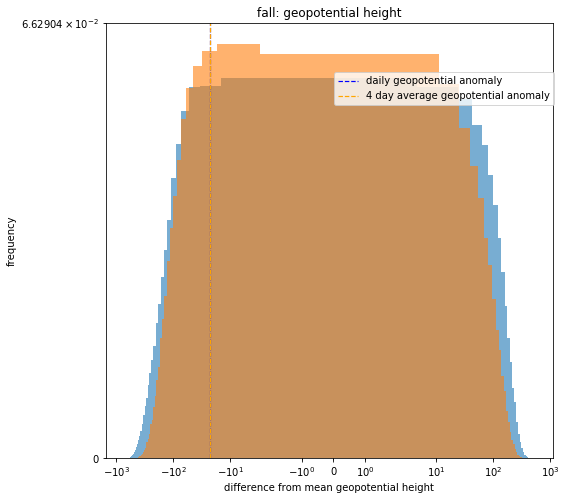

<Figure size 432x288 with 0 Axes>

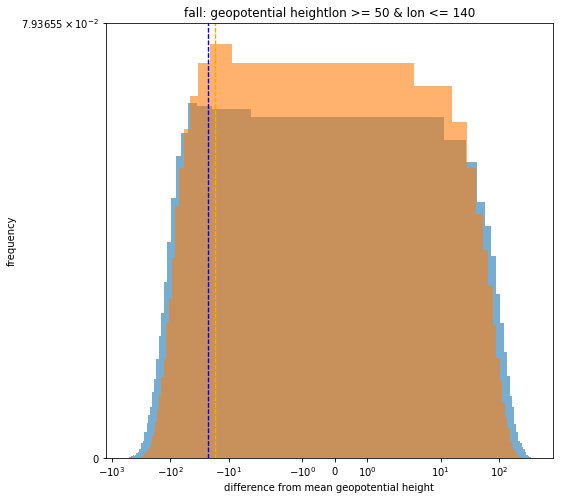

<Figure size 432x288 with 0 Axes>

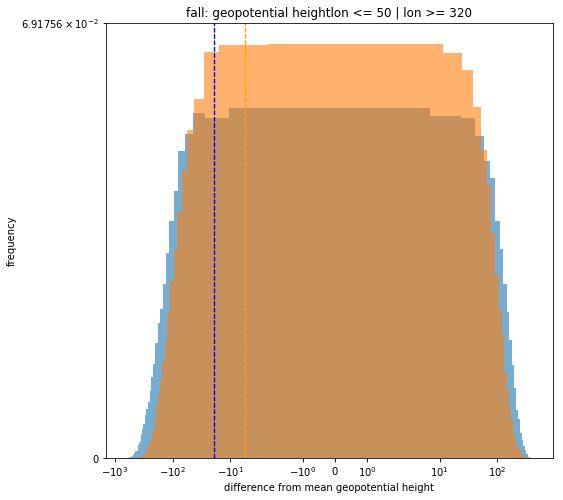

<Figure size 432x288 with 0 Axes>

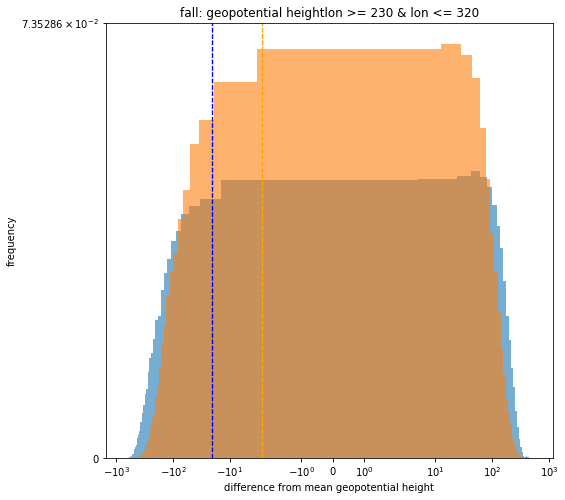

<Figure size 432x288 with 0 Axes>

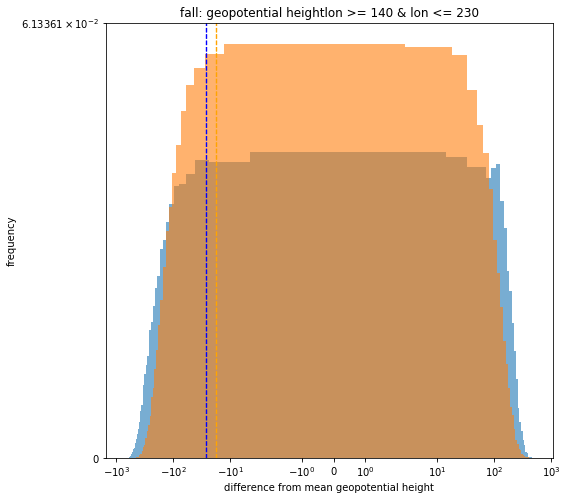

In [73]:
#drop the duplicates so am only pltting one point in each place
day_df = geopot_df.drop_duplicates(subset=['dayavg'], keep='first', inplace=False)
label_list = ["daily geopotential anomaly", "4 day average geopotential anomaly"]

for season in season_list:
    
    #display season
    display(Markdown('## season: ' + season))
    
    #get the correct dataframe
    plot_df = day_df[day_df["season"] == season]
    plot4_df = avg4_df[avg4_df["season"] == season]
    
    #plot the histogram for the entire season
    plt.clf();
    plt.figure(figsize=(8,8))
    plt.hist(plot_df['difference_month'], bins = 60, alpha = .6,
             weights = np.ones_like(plot_df.index) / len(plot_df.index))
    plt.hist(plot4_df['difference_month'], bins = 60, alpha = .6,
             weights = np.ones_like(plot4_df.index) / len(plot4_df.index))
    plt.axvline(plot_df['difference_month'].mean(), color='blue', linestyle='dashed', linewidth=1.2)
    plt.axvline(plot4_df['difference_month'].mean(), color='orange', linestyle='dashed', linewidth=1.2)
    plt.legend(label_list, bbox_to_anchor=[0.5, 0.8],ncol=1)
    plt.xscale('symlog')
    plt.yscale('symlog')
    plt.ylabel('frequency')
    plt.xlabel('difference from mean geopotential height')
    plt.title(season + ': geopotential height');
    plt.show()
    
    
    
    for section in lon_sections:
        
        #get the correct dataframe
        section_df = plot_df.query(section)
        section4_df = avg4_df.query(section)
        
        #plot the figure
        plt.clf();
        plt.figure(figsize=(8,8))
        plt.hist(section_df['difference_month'], bins = 60, alpha = .6,
                weights = np.ones_like(section_df.index) / len(section_df.index))
        plt.hist(section4_df['difference_month'], bins = 60, alpha = .6,
                weights = np.ones_like(section4_df.index) / len(section4_df.index))
        plt.axvline(section_df['difference_month'].mean(), color='blue', linestyle='dashed', linewidth=1.2)
        plt.axvline(section4_df['difference_month'].mean(), color='orange', linestyle='dashed', linewidth=1.2)
        plt.axvline(section_df['difference_month'].mean(), color='blue', linestyle='dashed', linewidth=1.2)
        plt.axvline(section4_df['difference_month'].mean(), color='orange', linestyle='dashed', linewidth=1.2)
        plt.ylabel('frequency')
        plt.xscale('symlog')
        plt.yscale('symlog')
        plt.xlabel('difference from mean geopotential height')
        plt.title(season + ': geopotential height' + section);
        plt.show()
        
    i = i + 1

## seasonal means as a function of year and longitude

In [13]:
#create a list of years and a gradient color pallete
# so there is at least some sense of what year each line is?
year_list = [1979 + i for i in range(year_number)]

colormap = plt.cm.gist_ncar
colors = [colormap(i) for i in np.linspace(0, 0.9, year_number)]

In [14]:
#drop the duplicates so am only pltting one point in each place
season_df = geopot_df.drop_duplicates(subset=['seasonmean'], keep='first', inplace=False)

/home/clairev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  


<Figure size 432x288 with 0 Axes>

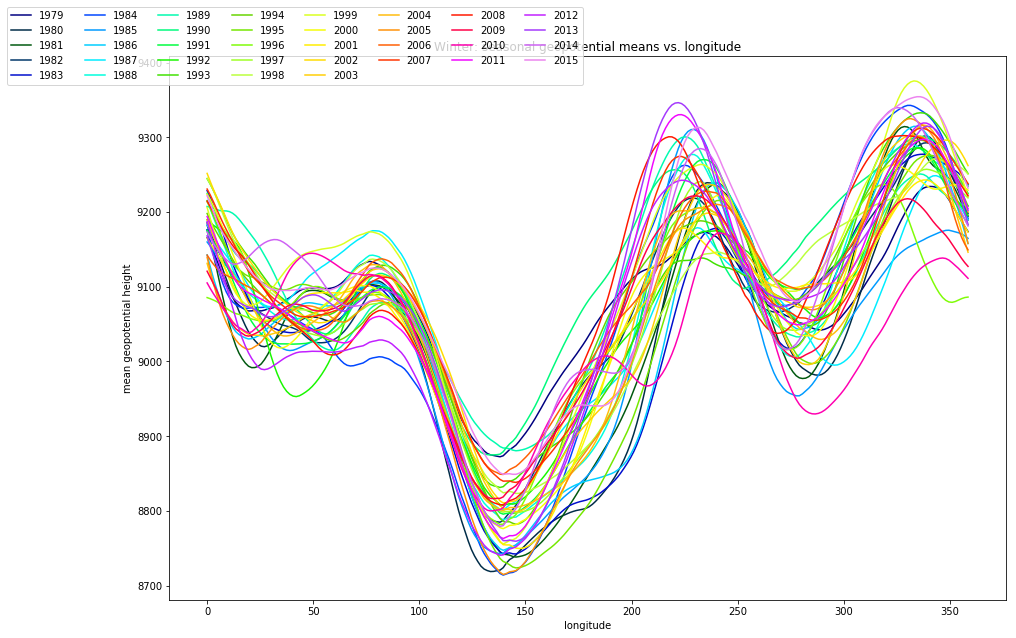

In [15]:
winter_df = season_df[season_df['season'] == "winter"]


plt.clf();
plt.figure(figsize=(15,10))
plt.gca().set_color_cycle(colors)
for year_chk in year_list:
    frame = winter_df[winter_df['year'] == year_chk]
    plt.plot(frame["lon"], frame["seasonmean"])
#plt.legend(bbox_to_anchor=(1.05,0.5))
plt.legend(year_list, bbox_to_anchor=[0.5, 1.1],
          ncol=8)
plt.title("Winter: seasonal geopotential means vs. longitude")
plt.xlabel("longitude")
#plt.xlim((0, 350)) 
plt.ylabel("mean geopotential height")
plt.show()

/home/clairev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  """


<Figure size 432x288 with 0 Axes>

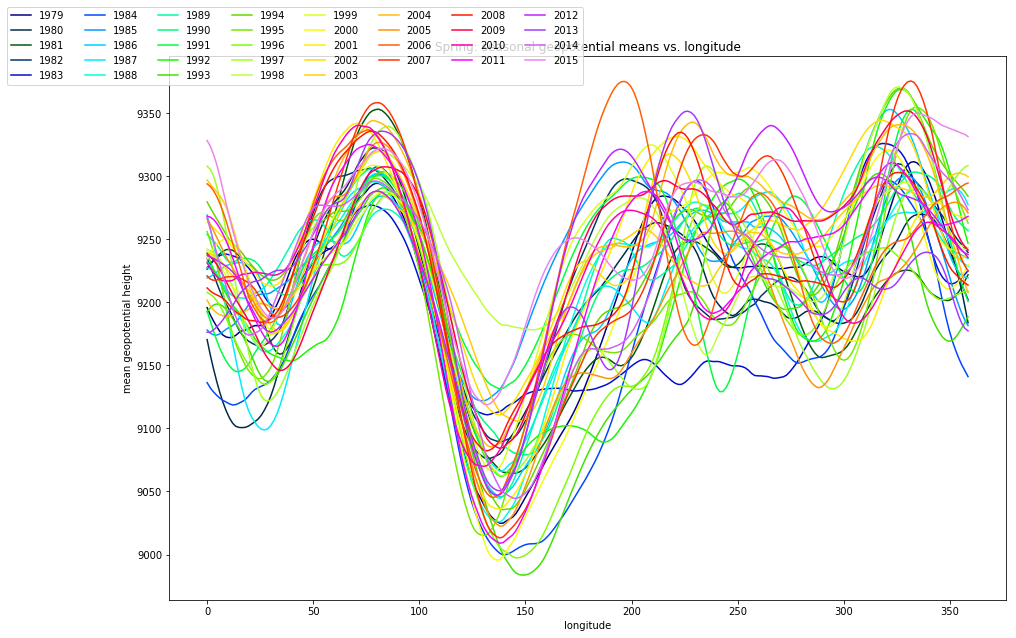

In [16]:
spring_df = season_df[season_df['season'] == "spring"]

plt.clf();
plt.figure(figsize=(15,10))
plt.gca().set_color_cycle(colors)
for year_chk in year_list:
    frame = spring_df[spring_df['year'] == year_chk]
    plt.plot(frame["lon"], frame["seasonmean"])
plt.legend(year_list, bbox_to_anchor=[0.5, 1.1],
          ncol=8)
plt.title("Spring: seasonal geopotential means vs. longitude")
plt.xlabel("longitude")
plt.ylabel("mean geopotential height")
plt.show()

/home/clairev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  """


<Figure size 432x288 with 0 Axes>

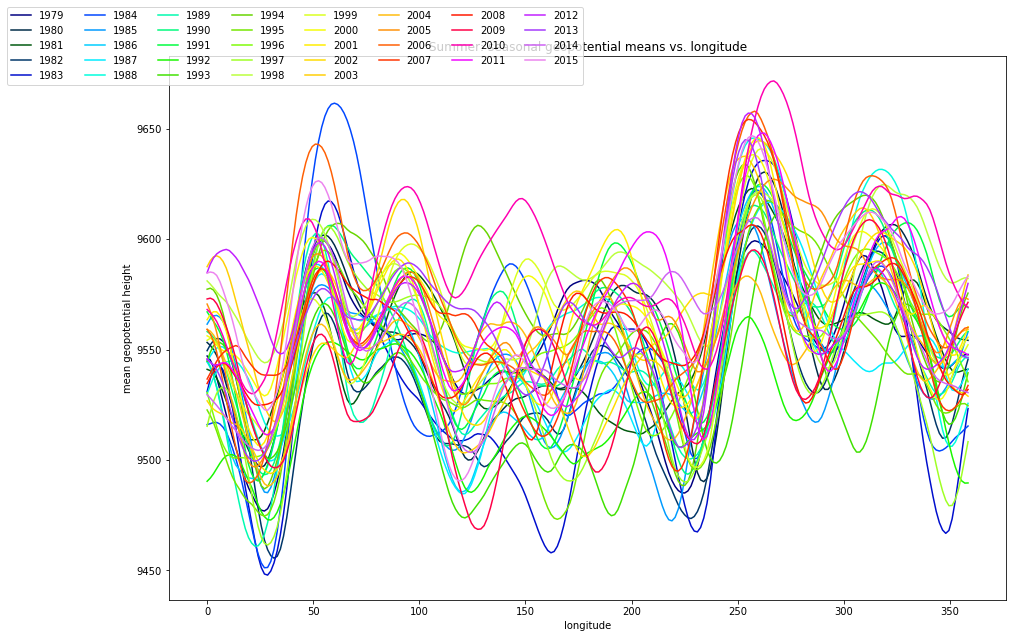

In [17]:
summer_df = season_df[season_df['season'] == "summer"]

plt.clf();
plt.figure(figsize=(15,10))
plt.gca().set_color_cycle(colors)
for year_chk in year_list:
    frame = summer_df[summer_df['year'] == year_chk]
    plt.plot(frame["lon"], frame["seasonmean"])
#plt.legend(bbox_to_anchor=(1.05,0.5))
plt.legend(year_list, bbox_to_anchor=[0.5, 1.1],
          ncol=8)
plt.title("Summer: seasonal geopotential means vs. longitude")
plt.xlabel("longitude")
plt.ylabel("mean geopotential height")
plt.show()

/home/clairev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.
  """


<Figure size 432x288 with 0 Axes>

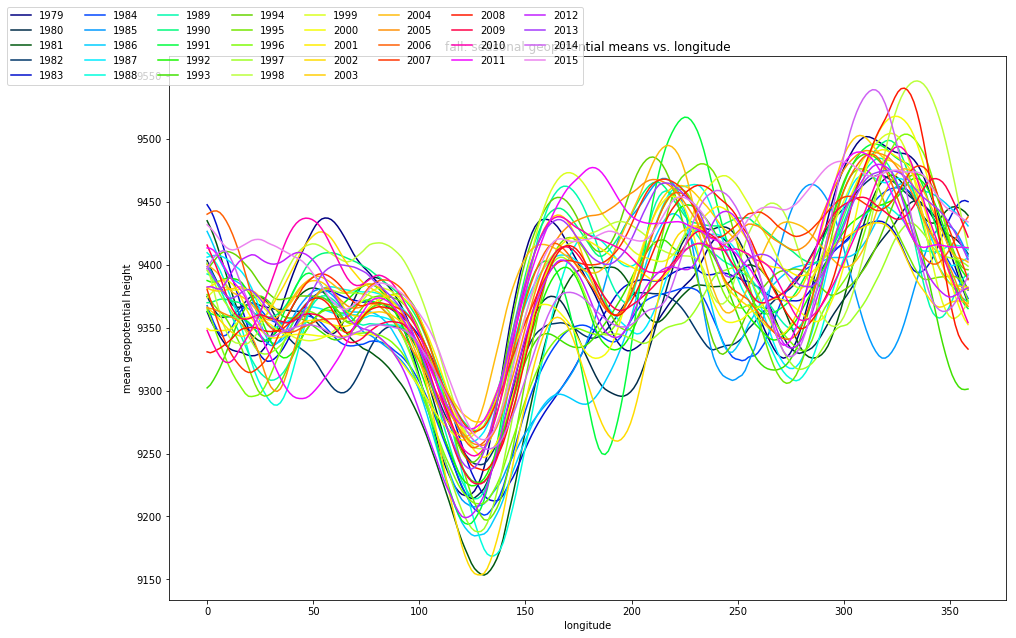

In [18]:
fall_df = season_df[season_df['season'] == "fall"]

plt.clf();
plt.figure(figsize=(15,10))
plt.gca().set_color_cycle(colors)
for year_chk in year_list:
    frame = fall_df[fall_df['year'] == year_chk]
    plt.plot(frame["lon"], frame["seasonmean"])
plt.legend(year_list, bbox_to_anchor=[0.5, 1.1],
          ncol=8)
plt.title("fall: seasonal geopotential means vs. longitude")
plt.xlabel("longitude")
plt.ylabel("mean geopotential height")
plt.show()

## Departure from the mean of geopotential height as a function of month (over all years)
At each grid point average the monthly mean values over 38 years to compute climatological mean, monthly-mean value (thereby we remove the interannual variability)

In [26]:
#create a list of seasons to cycle through
season_list = ["winter", "spring", "summer", "fall"]

## season: winter

<Figure size 432x288 with 0 Axes>

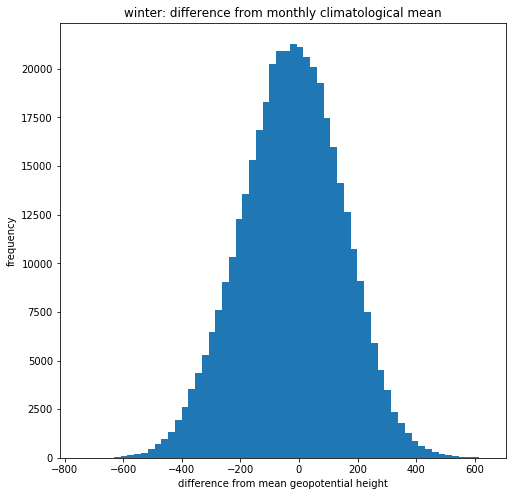

<Figure size 432x288 with 0 Axes>

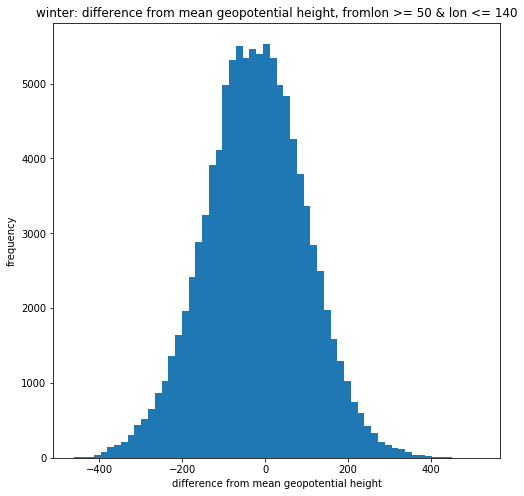

<Figure size 432x288 with 0 Axes>

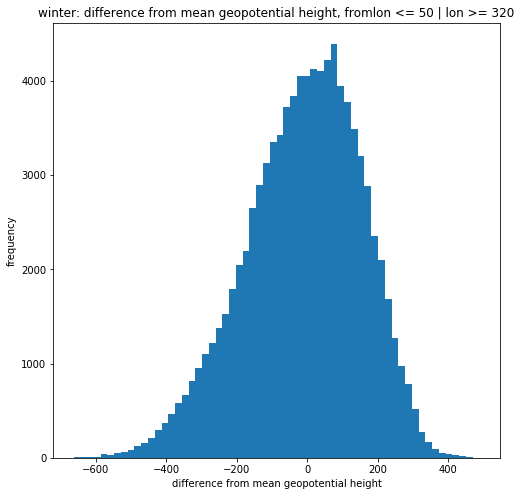

<Figure size 432x288 with 0 Axes>

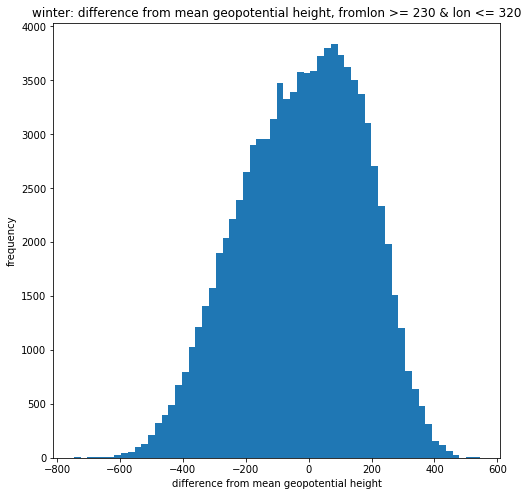

<Figure size 432x288 with 0 Axes>

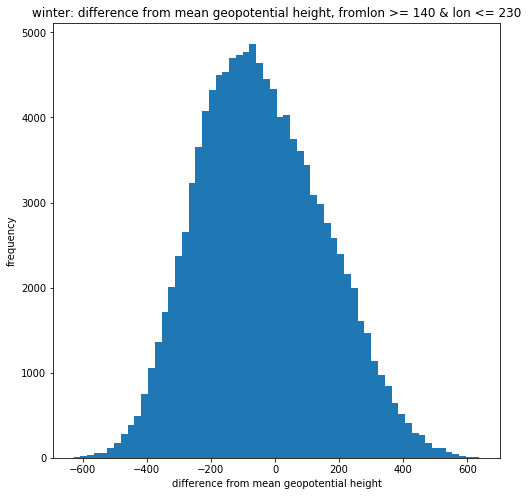

## season: spring

<Figure size 432x288 with 0 Axes>

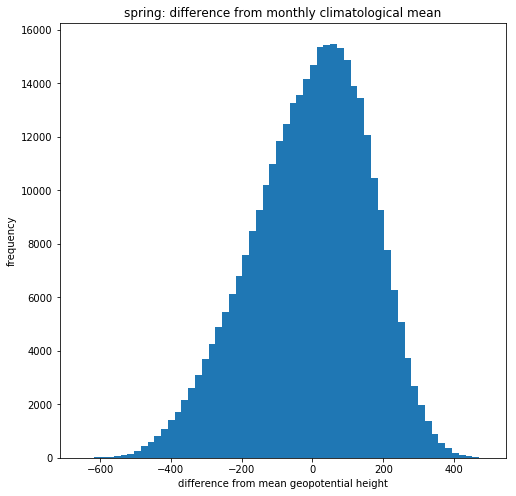

<Figure size 432x288 with 0 Axes>

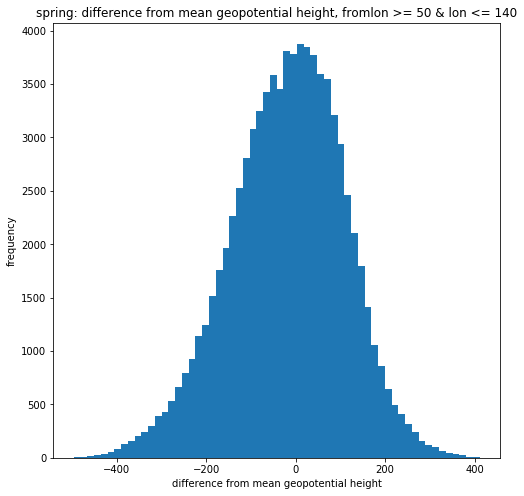

<Figure size 432x288 with 0 Axes>

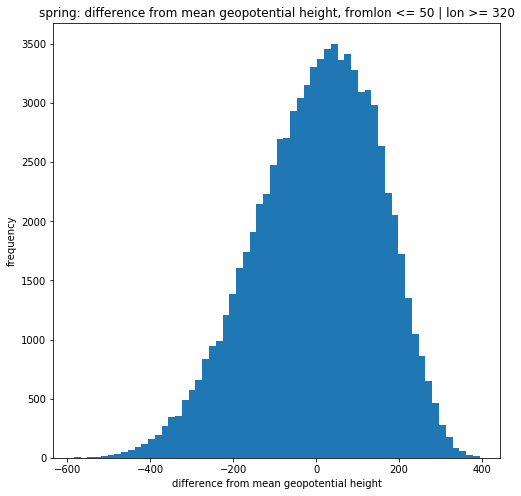

<Figure size 432x288 with 0 Axes>

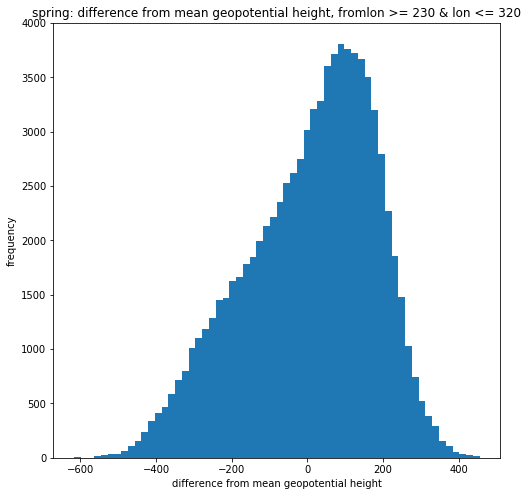

<Figure size 432x288 with 0 Axes>

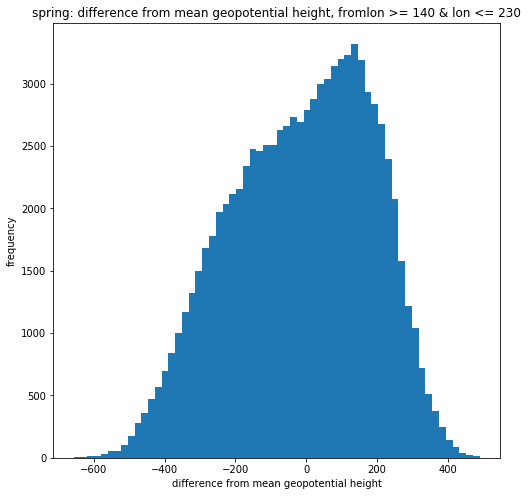

## season: summer

<Figure size 432x288 with 0 Axes>

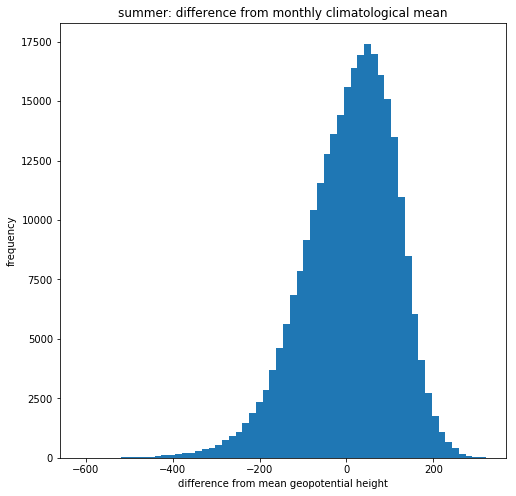

<Figure size 432x288 with 0 Axes>

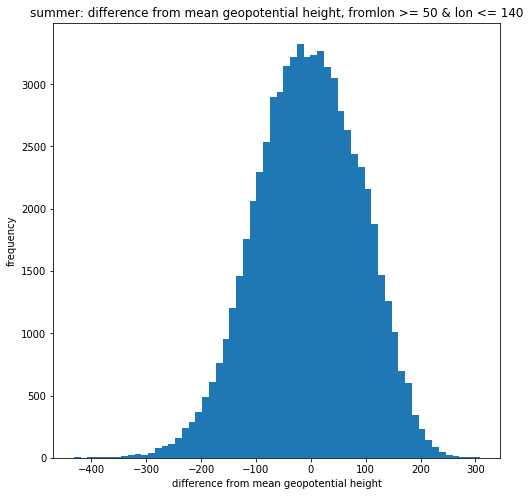

<Figure size 432x288 with 0 Axes>

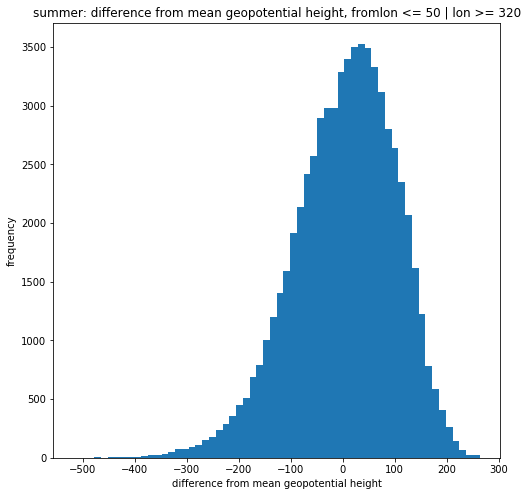

<Figure size 432x288 with 0 Axes>

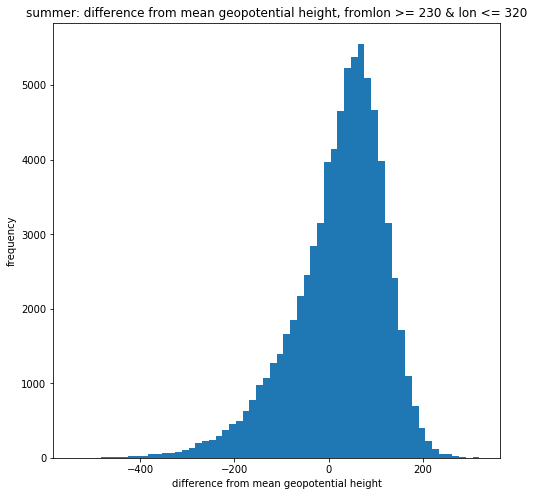

<Figure size 432x288 with 0 Axes>

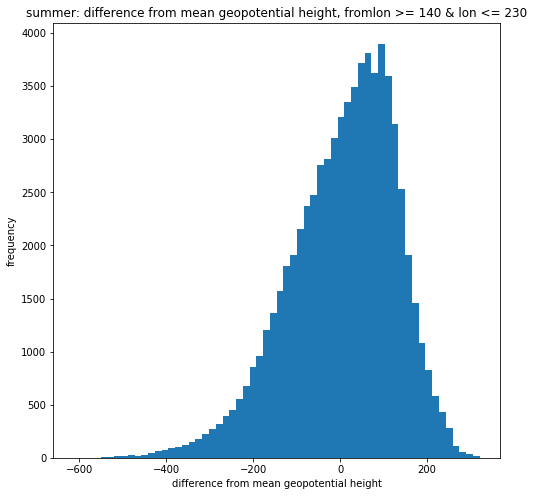

## season: fall

<Figure size 432x288 with 0 Axes>

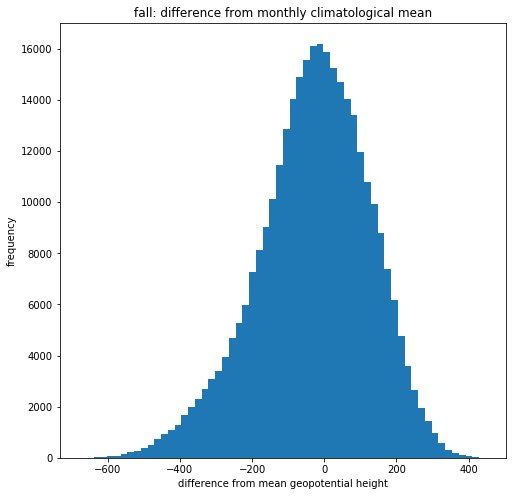

<Figure size 432x288 with 0 Axes>

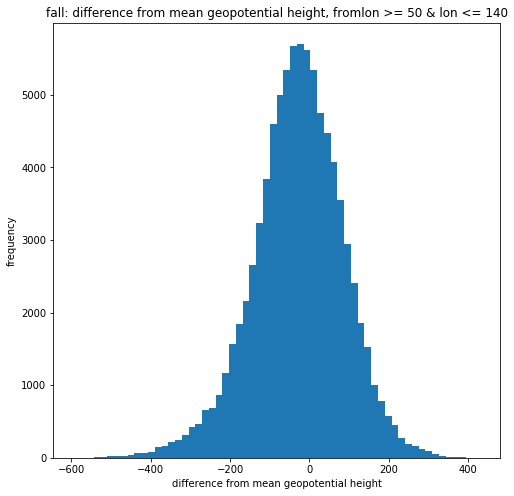

<Figure size 432x288 with 0 Axes>

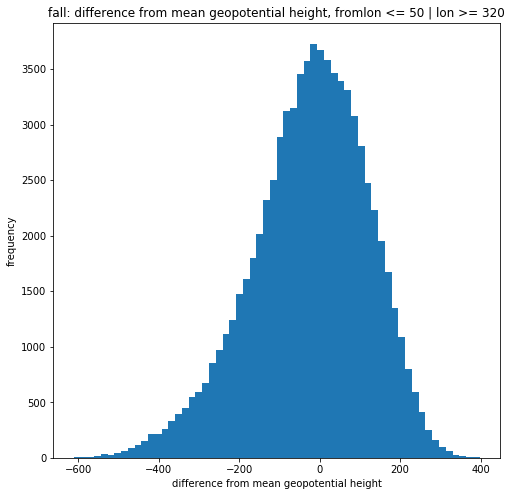

<Figure size 432x288 with 0 Axes>

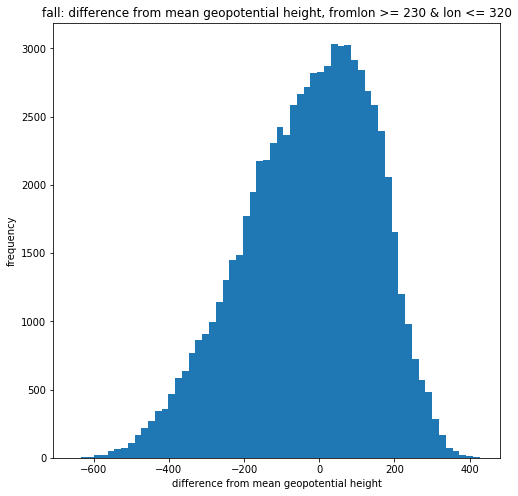

<Figure size 432x288 with 0 Axes>

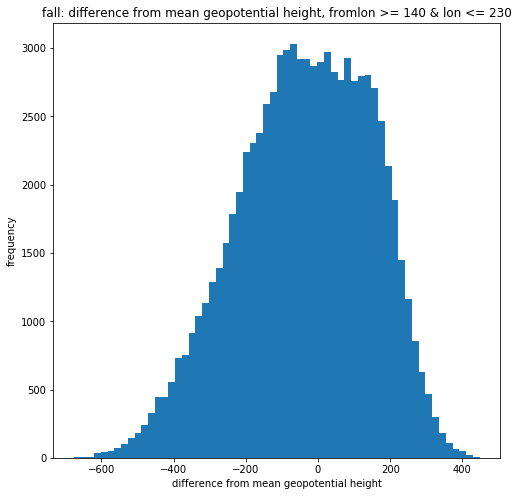

In [27]:
#drop the duplicates so am only pltting one point in each place
day_df = geopot_df.drop_duplicates(subset=['dayavg'], keep='first', inplace=False)

for season in season_list:
    
    #display season
    display(Markdown('## season: ' + season))
    
    #get the correct dataframe
    plot_df = day_df[day_df["season"] == season]
    
    #plot the histogram for the entire season
    plt.clf();
    plt.figure(figsize=(8,8))
    plt.hist(plot_df['difference_climmonth'], bins = 60)
    #plt.xlim(xmin,xmax)
    plt.ylabel('frequency')
    plt.xlabel('difference from mean geopotential height')
    plt.title(season + ': difference from monthly climatological mean');
    plt.show()
    
    
    
    for section in lon_sections:
        
        #get the correct dataframe
        section_df = plot_df.query(section)
        
        #plot the figure
        plt.clf();
        plt.figure(figsize=(8,8))
        plt.hist(section_df['difference_climmonth'], bins = 60)
        plt.ylabel('frequency')
        plt.xlabel('difference from mean geopotential height')
        plt.title(season + ': difference from mean geopotential height, from' + section);
        plt.show()
        
    i = i + 1

## Departure of Geopotential Mean (Four day average)
These histograms are the departure of the geopotential mean for a four day average, in order to compare with previous histograms (1 day average). For the 1 day average, the distributions are roughly symmetric, do the four-day average values show a longer tail in ridges/positive?

## season: winter

<Figure size 432x288 with 0 Axes>

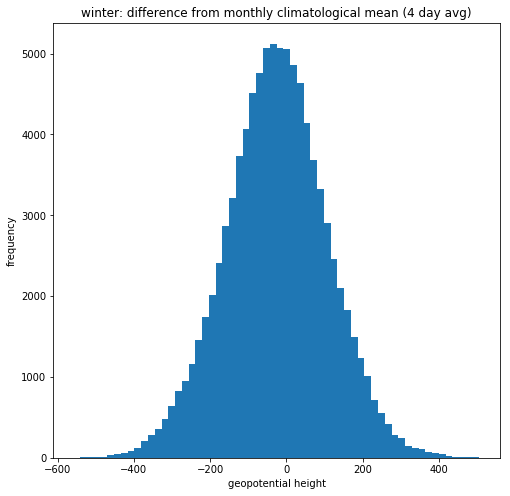

<Figure size 432x288 with 0 Axes>

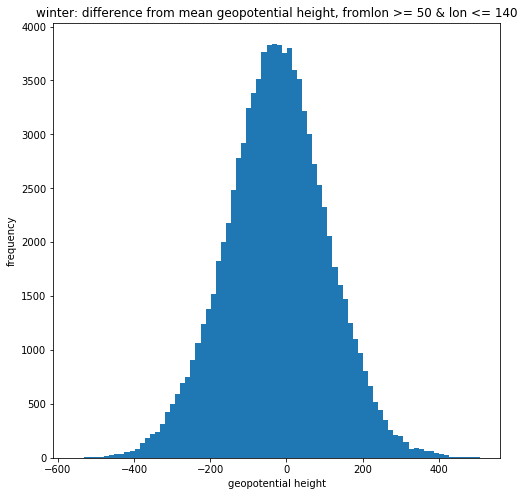

<Figure size 432x288 with 0 Axes>

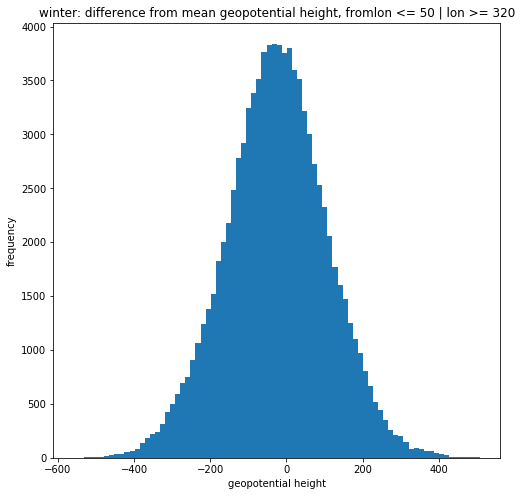

<Figure size 432x288 with 0 Axes>

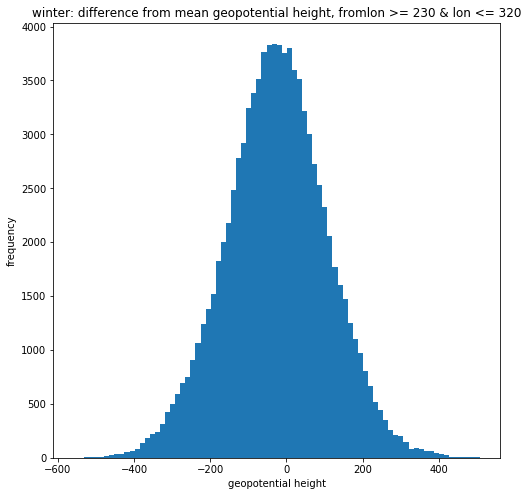

<Figure size 432x288 with 0 Axes>

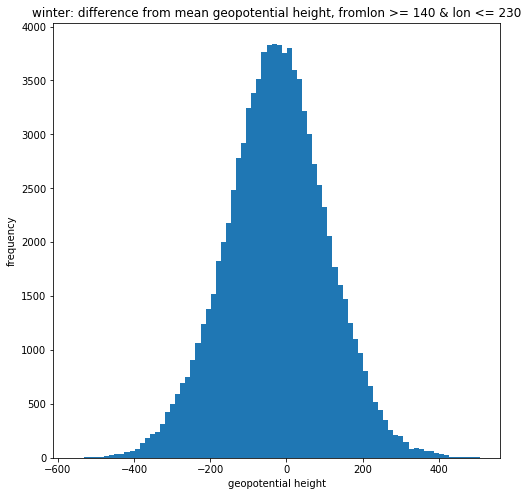

## season: spring

<Figure size 432x288 with 0 Axes>

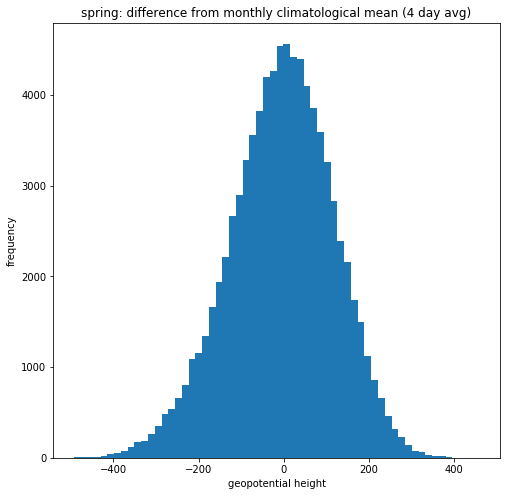

<Figure size 432x288 with 0 Axes>

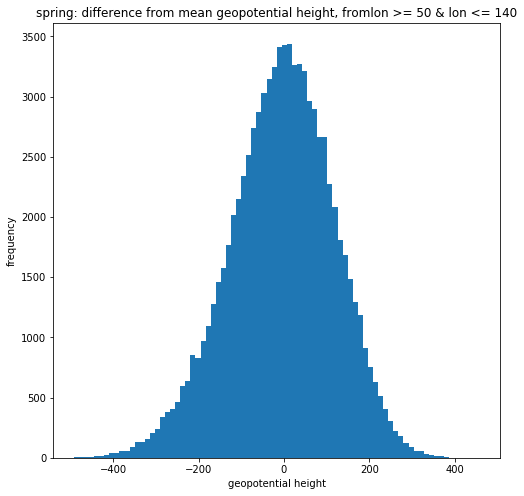

<Figure size 432x288 with 0 Axes>

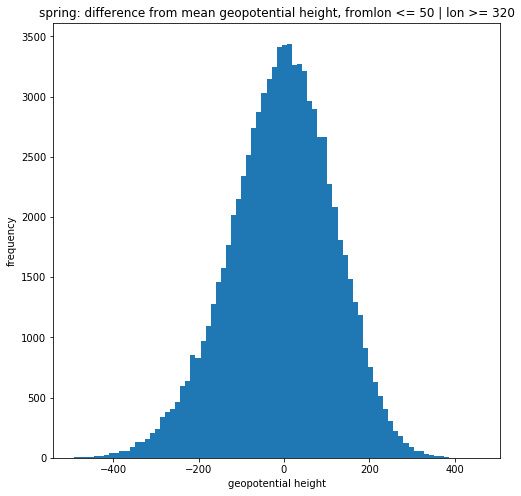

<Figure size 432x288 with 0 Axes>

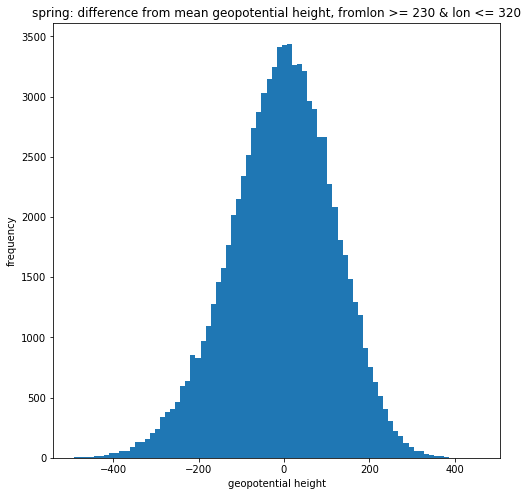

<Figure size 432x288 with 0 Axes>

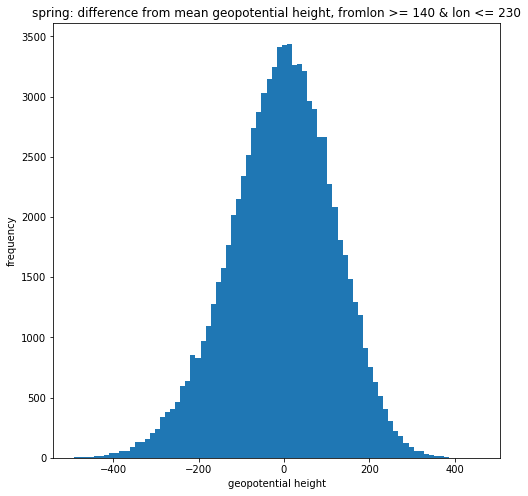

## season: summer

<Figure size 432x288 with 0 Axes>

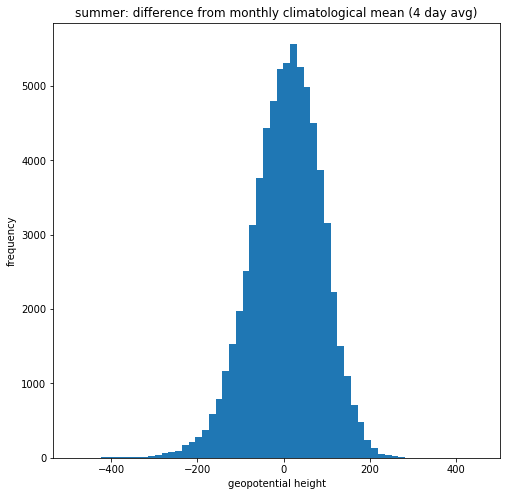

<Figure size 432x288 with 0 Axes>

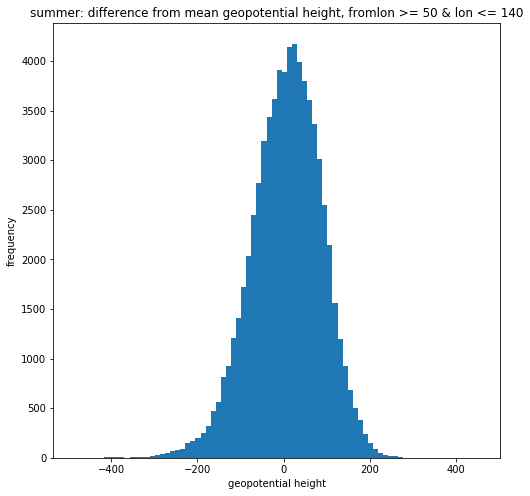

<Figure size 432x288 with 0 Axes>

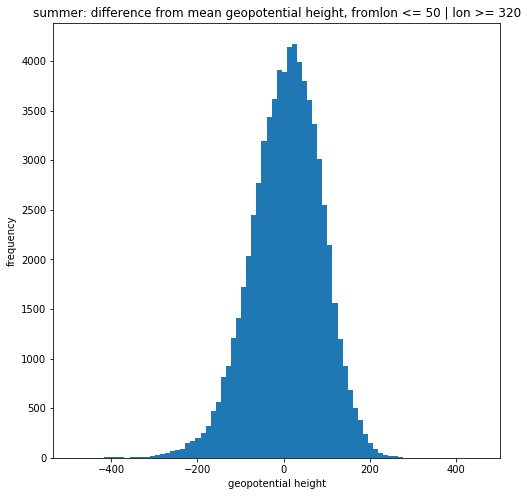

<Figure size 432x288 with 0 Axes>

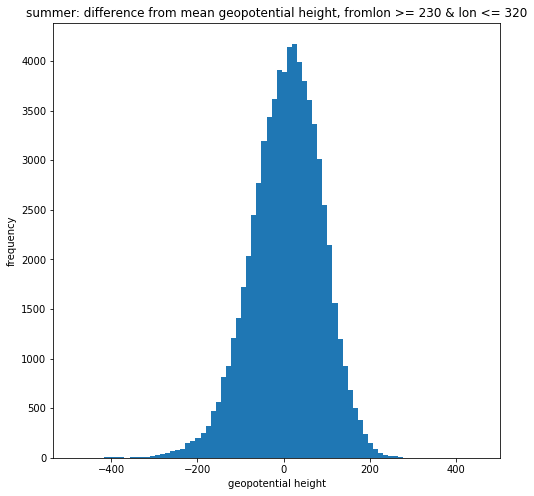

<Figure size 432x288 with 0 Axes>

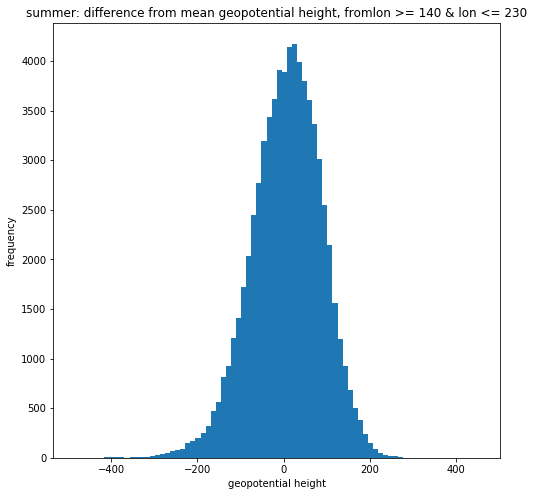

## season: fall

<Figure size 432x288 with 0 Axes>

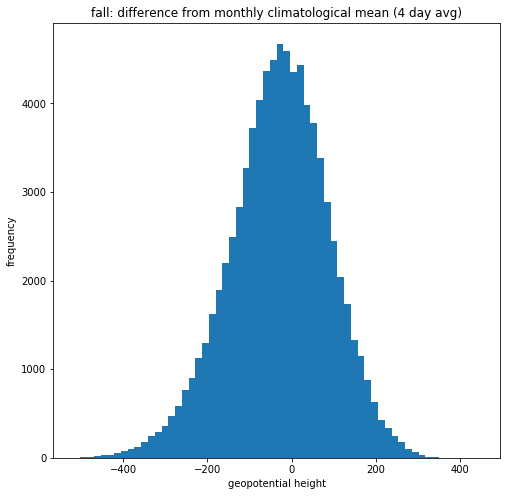

<Figure size 432x288 with 0 Axes>

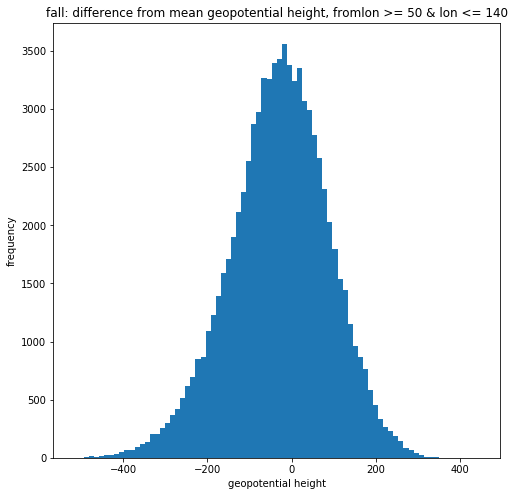

<Figure size 432x288 with 0 Axes>

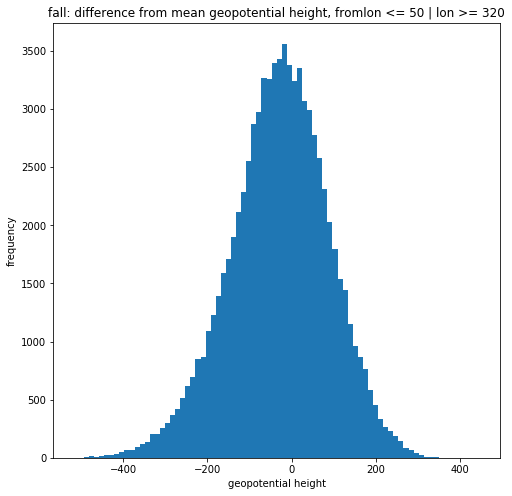

<Figure size 432x288 with 0 Axes>

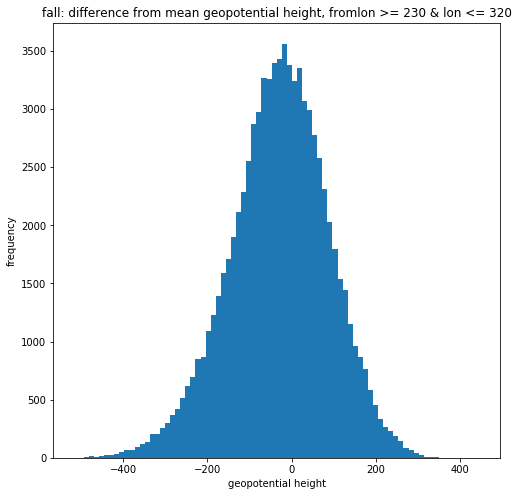

<Figure size 432x288 with 0 Axes>

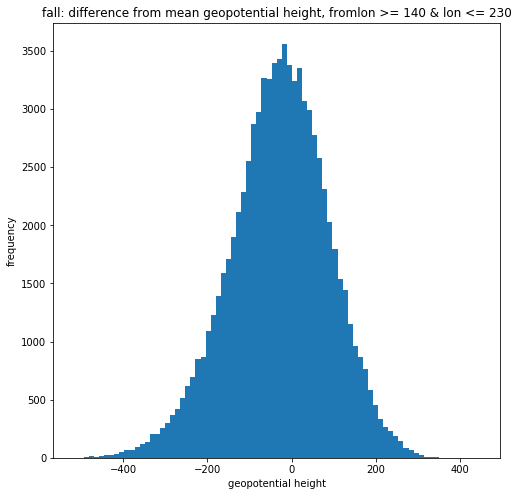

In [28]:
day4_df = avg4_df.drop_duplicates(subset=['dayavg'], keep='first', inplace=False)

i = 0
for season in season_list:
    
    #display season
    display(Markdown('## season: ' +season))
    
    #get the correct dataframe
    season_df = day4_df[day4_df['season'] == season] 
    
    #plot the histogram for the entire season
    plt.clf();
    plt.figure(figsize=(8,8))
    plt.hist(season_df['difference_climmonth'], bins = 60)
    #plt.xlim(xmin,xmax)
    plt.ylabel('frequency')
    plt.xlabel('geopotential height')
    plt.title(season + ': difference from monthly climatological mean (4 day avg)');
    plt.show()
    
    
    
    for section in lon_sections:
        
        #get the correct dataframe
        section_df = day_df.query(section)
        
        #plot the figure
        plt.clf();
        plt.figure(figsize=(8,8))
        plt.hist(season_df['difference_climmonth'], bins = 80)
        plt.ylabel('frequency')
        plt.xlabel('geopotential height')
        plt.title(season + ': difference from mean geopotential height, from' + section);
        plt.show()
        
    i = i + 1

# Geopotential height histograms

these are the histograms that show geopotential height for each season (over every year) and for each section individually

## season: winter

<Figure size 432x288 with 0 Axes>

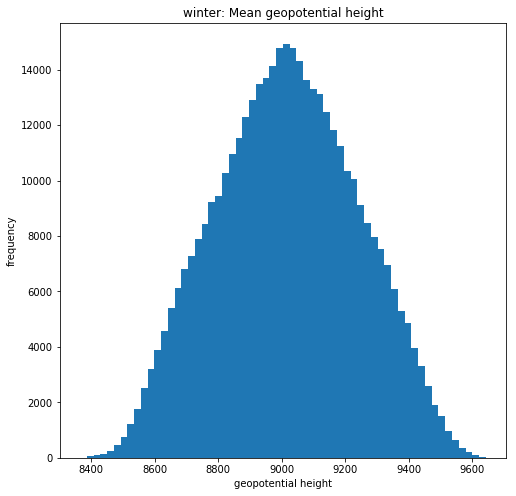

<Figure size 432x288 with 0 Axes>

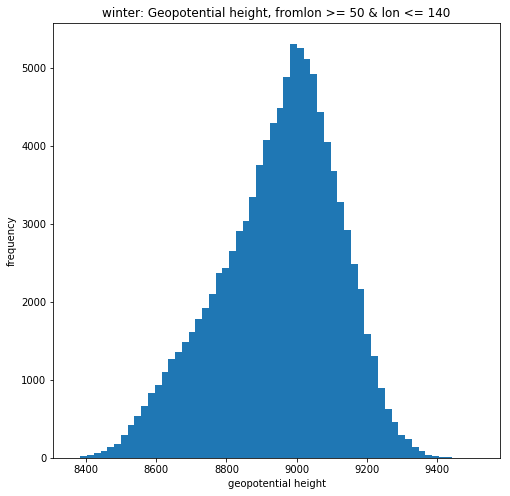

<Figure size 432x288 with 0 Axes>

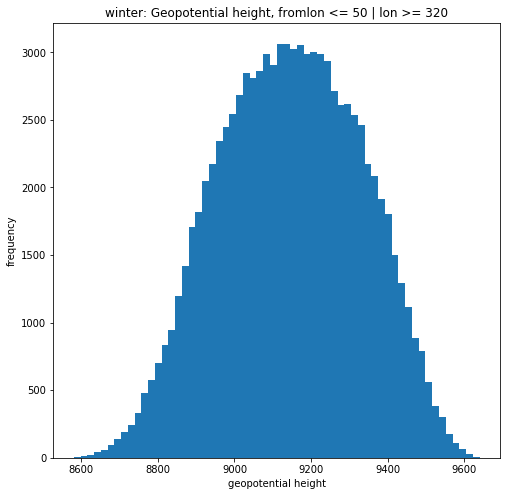

<Figure size 432x288 with 0 Axes>

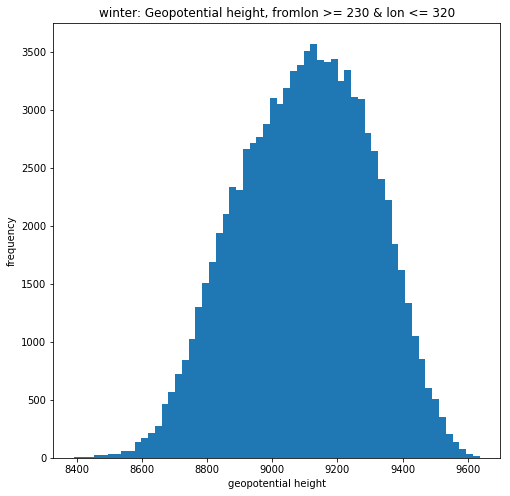

<Figure size 432x288 with 0 Axes>

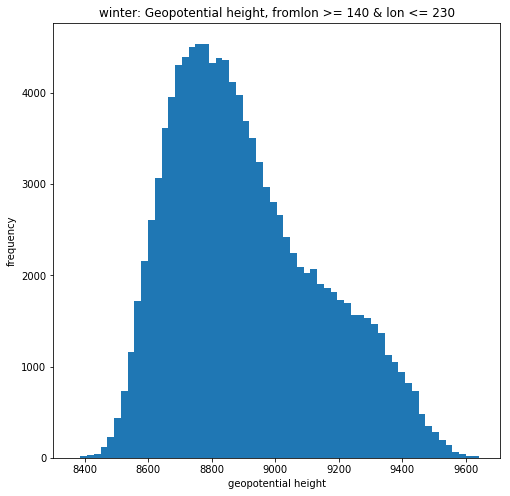

## season: spring

<Figure size 432x288 with 0 Axes>

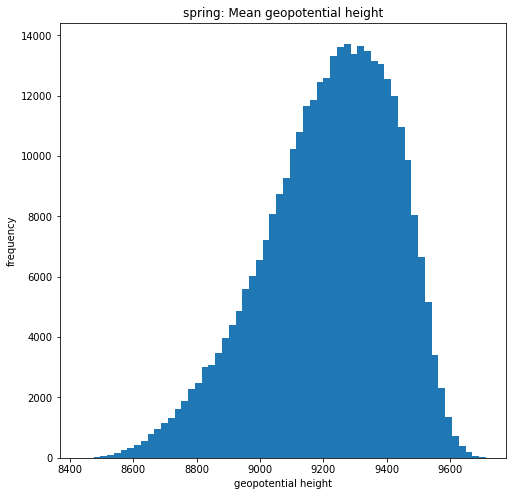

<Figure size 432x288 with 0 Axes>

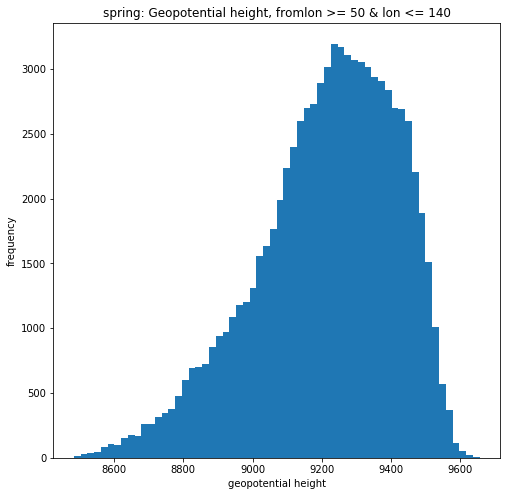

<Figure size 432x288 with 0 Axes>

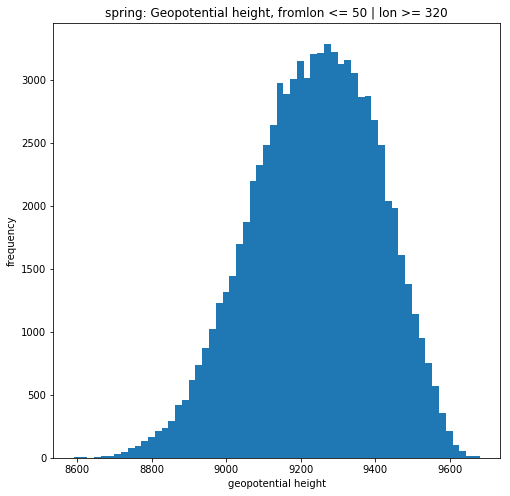

<Figure size 432x288 with 0 Axes>

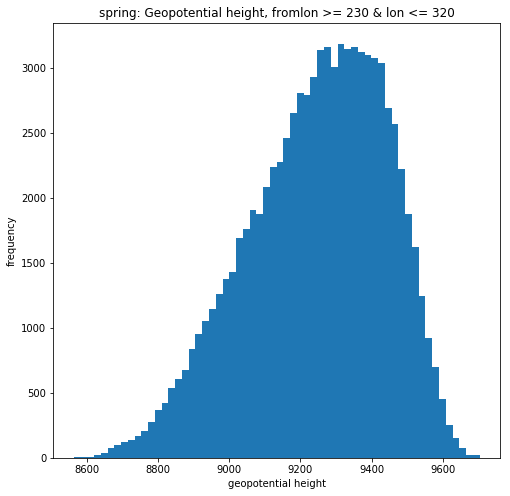

<Figure size 432x288 with 0 Axes>

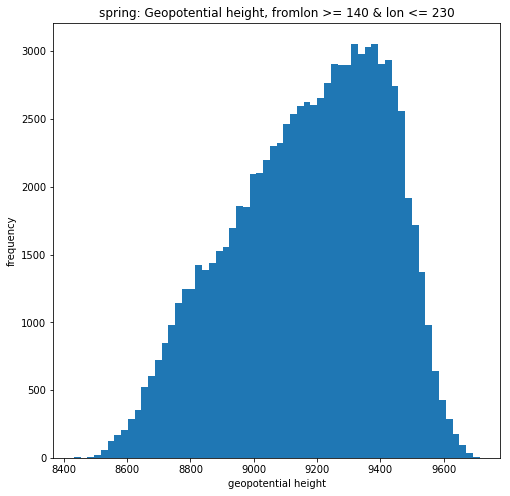

## season: summer

<Figure size 432x288 with 0 Axes>

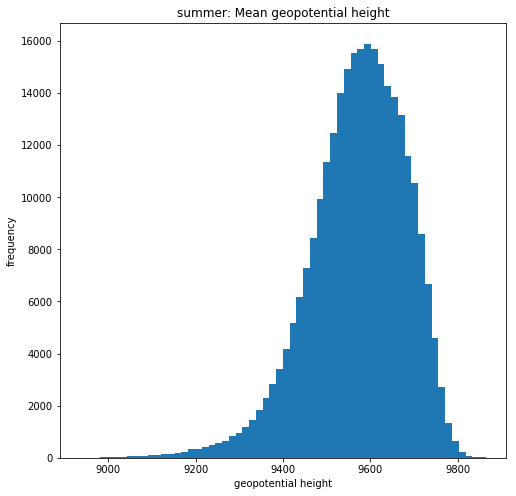

<Figure size 432x288 with 0 Axes>

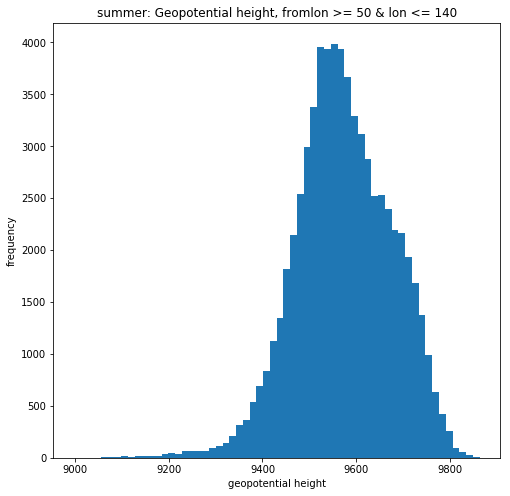

<Figure size 432x288 with 0 Axes>

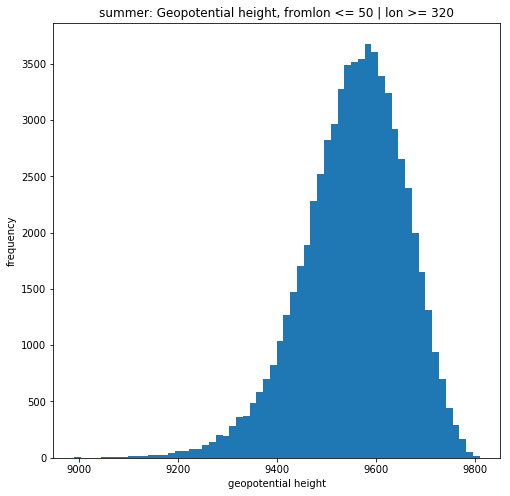

<Figure size 432x288 with 0 Axes>

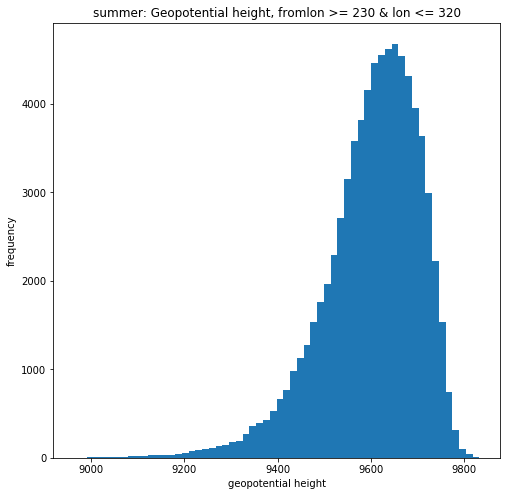

<Figure size 432x288 with 0 Axes>

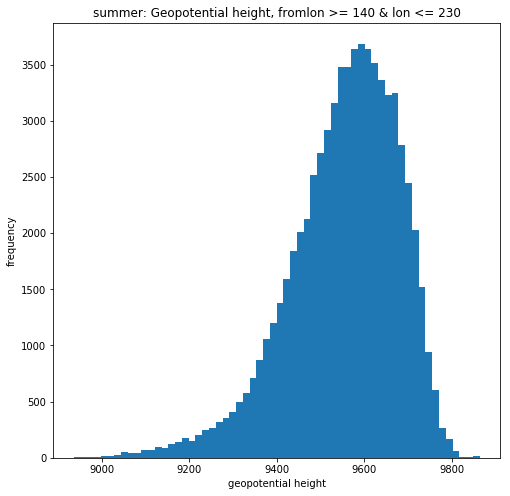

## season: fall

<Figure size 432x288 with 0 Axes>

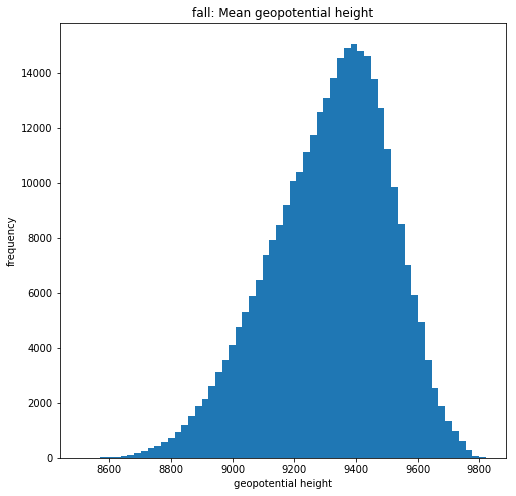

<Figure size 432x288 with 0 Axes>

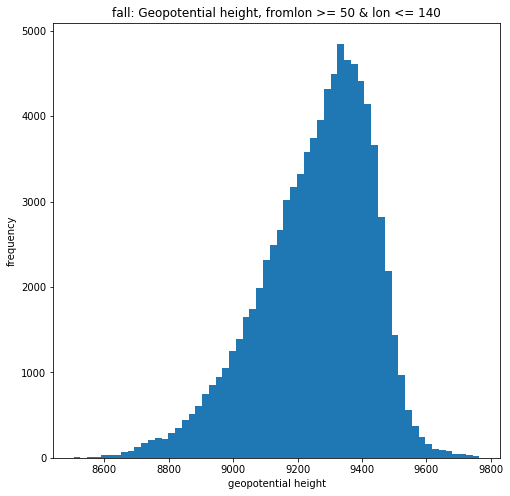

<Figure size 432x288 with 0 Axes>

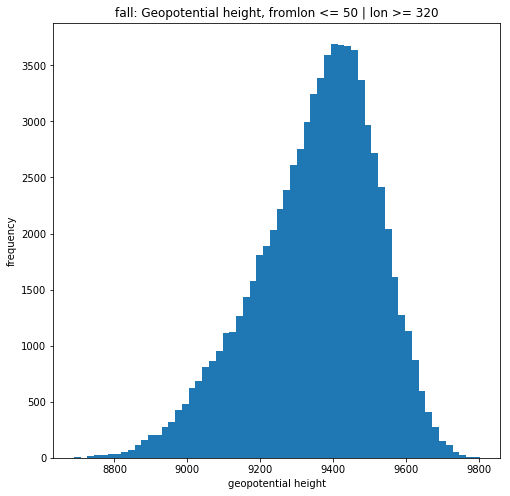

<Figure size 432x288 with 0 Axes>

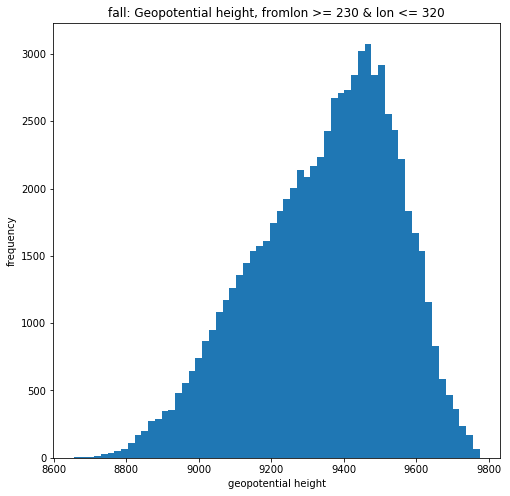

<Figure size 432x288 with 0 Axes>

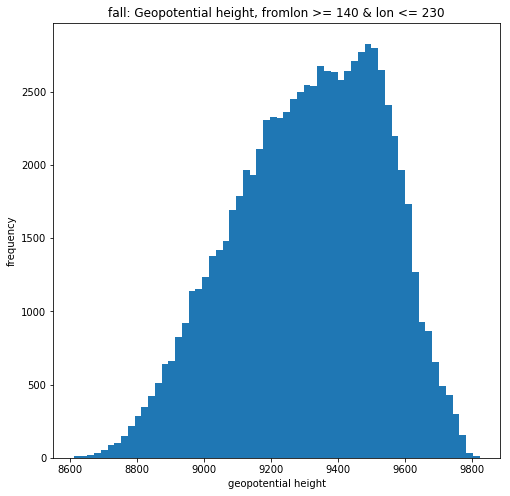

In [25]:
#drop the duplicates so am only pltting one point in each place
day_df = geopot_df.drop_duplicates(subset=['dayavg'], keep='first', inplace=False)

i = 0
for season in season_list:
    
    #display season
    display(Markdown('## season: ' + season))
    
    #get the correct dataframe
    plot_df = day_df[day_df["season"] == season]
    
    #plot the histogram for the entire season
    plt.clf();
    plt.figure(figsize=(8,8))
    plt.hist(plot_df['dayavg'], bins = 60)
    #plt.xlim(xmin,xmax)
    plt.ylabel('frequency')
    plt.xlabel('geopotential height')
    plt.title(str(season_label[i]) + ': Mean geopotential height');
    plt.show()
    
    
    
    for section in lon_sections:
        
        #get the correct dataframe
        section_df = plot_df.query(section)
        
        #plot the figure
        plt.clf();
        plt.figure(figsize=(8,8))
        plt.hist(section_df['dayavg'], bins = 60)
        plt.ylabel('frequency')
        plt.xlabel('geopotential height')
        plt.title(str(season_label[i]) + ': Geopotential height, from' + section);
        plt.show()
        
    i = i + 1